# RANZCR CLiP - Medaled Solution Notebook (Revised Plan)

## Objective
- Metric: AUC-ROC
- Output: submission.csv
- Targets: Bronze ≥ 0.97090, Silver ≥ 0.97152, Gold ≥ 0.97357

## 0) Reproducibility & Ops
- Global seeds: numpy/torch/random; torch.backends.cudnn.deterministic=True; benchmark=False.
- Capture env: python/pkg versions, CUDA, timm/albumentations versions.
- Experiment logging (structured): run_id, timestamp, data versions (file hashes, counts), code git/hash, config (model, size, aug, loss, opt, lr schedule, epochs, batch, folds, CV splitter, group key), CV scores (macro AUC, per-label AUC), OOF paths, checkpoints, inference/TTA config, submission path.
- Notebook backups before major changes.

## 1) Data Inventory & Strategy
- Programmatically list files/dirs; read CSV schemas:
  - train.csv (verify id/key cols; likely StudyInstanceUID/ImageID/PatientID + 11 targets).
  - sample_submission.csv (defines exact target column order).
  - train_annotations.csv (if present): bounding boxes per device/region.
  - train/ and test/ images (jpg/png).
- Verify grouping key: prefer StudyInstanceUID; fallback PatientID. Use programmatic checks (n unique per key).
- If annotations exist:
  - Generate auxiliary supervision: per-class heatmaps from boxes.
  - ROI crops: create tight crops around devices (ETT/NGT/CVC/SGT) to feed a small head or as multi-scale inputs.
  - Attention priors: blur outside union of boxes; or add extra channel with gaussian masks.
- Medical preprocessing:
  - Use x-ray friendly normalization (single-channel or 3x replicated with chest radiograph means) and histogram equalization/CLAHE (light).
  - Optional lung/mediastinum segmentation (pretrained U-Net on CXR) to mask/weight regions; plan as an experiment if time allows.
  - Prefer backbones pretrained on chest x-ray datasets (CheXpert/MIMIC/ChestX-ray14) when available in timm or via public weights.

## 2) Labels & Multi-Label Methodology
- Targets are multi-label with structured groups (e.g., ETT_Normal/Borderline/Abnormal mutually exclusive; same for NGT, CVC, SGT).
- Modeling strategy:
  - Multi-head, multi-class for each device group (softmax heads) plus binary heads for presence-type labels if any; map softmax outputs back to per-label probabilities aligned with sample_submission columns.
  - Parallel baseline: pure multi-label BCE/ASL head for comparison; ensemble both.
- Losses:
  - Start with BCEWithLogitsLoss with per-label pos_weight.
  - Try Asymmetric Focal Loss (ASL) and Focal BCE.
  - Label smoothing 0.01–0.05 for softmax heads.
- Thresholding:
  - Optimize per-label thresholds on OOF via AUC-friendly approach (Youden/J-statistic or maximize macro F2 proxy; for AUC reporting thresholds not needed, but for stacking/meta features and pseudo-labels they are).

## 3) Cross-Validation & Splits
- Grouped CV to prevent leakage: Group = StudyInstanceUID (or PatientID if confirmed).
- Stratification:
  - Use Iterative Stratification for multi-label balance at the group level. If libraries lack direct grouped-iterative split, perform iterative stratification on group-aggregated labels, then map groups to folds.
- Plan: 5 folds (fallback 3 if compute-bound). Track macro AUC and per-label AUC. Save OOF.

## 4) Baseline → Strong Models
- Image sizes: start 384–512; escalate to 640–768 where feasible.
- Augmentations (x-ray safe): RandomResizedCrop/Resize+CenterCrop, HorizontalFlip, small ShiftScaleRotate, RandomBrightnessContrast (±0.1–0.2), CLAHE (p≤0.2), Cutout/CoarseDropout small p, avoid heavy color jitter.
- Optimizer & schedule: AdamW (lr≈2e-4, wd≈1e-4), cosine with warmup; EMA; AMP; gradient accumulation if needed.
- Backbones (architectural diversity):
  1) ConvNeXt-Tiny/Base (ImageNet then try CXR-pretrained if available).
  2) EfficientNet-B3/B4 (and/or tf_efficientnet variants).
  3) SE-ResNeXt50_32x4d.
  4) ViT/Swin-Tiny/Small (transformers for diversity).
- Heads:
  - Multi-head softmax per device group + optional shared features; auxiliary BCE head for global presence if applicable.
  - Calibrate logits with temperature scaling on OOF if beneficial.
- Training: 5–8 epochs for baseline; extend to 12–20 at higher res. Early stopping on CV.

## 5) Annotations-Driven Experiments (if boxes exist)
- Two-stage pipeline:
  - Stage A: Lightweight detector/heatmap regressor to localize devices (supervised by boxes).
  - Stage B: Classifier consuming global image + ROI crops/heatmaps (concat channels or late fusion).
- Region prior augmentation: mask-downweight non-ROI; or multi-crop inference on detected ROIs.

## 6) Inference & Ensembling
- Fold-averaging; TTA (hflip, multi-scale 0.9x/1.0x/1.1x center crop).
- Model ensembling:
  - Diverse backbones (CNN + ViT) and loss variants (BCE/ASL) and multi-head vs BCE-only.
  - Weighted average by CV AUC; then stacking: XGBoost/LightGBM meta-learner on OOF probabilities (features = per-model per-label probs, plus simple interactions).
- Calibration: temperature scaling or Platt per label if it helps OOF AUC stability.

## 7) Advanced Boosts (time-permitting)
- Pseudo-labeling: 1–2 rounds with high-confidence test predictions (label-wise thresholds), retrain last 3–5 epochs.
- SWA after convergence; EMA maintained throughout.
- Multi-resolution training/inference.

## 8) Checkpoints & Audits
- After this revised plan (require approval).
- After data loading + inventory validation + EDA.
- After baseline CV run and first submission.
- After multi-head models and ensembling.
- Before final submission.

## 9) Experiment Log Template
- run_id: 
- timestamp: 
- data_inventory: {train.csv hash/rows, sample_submission hash/rows, annotations present?: bool + hash/rows, n_train_imgs, n_test_imgs}
- grouping_key: 
- config: {model, size, aug, loss, opt, lr, schedule, epochs, batch, folds, TTA, heads, pos_weight, seed}
- cv_scores: {macro_auc, per_label_auc: dict}
- oof_path: 
- checkpoints: [paths]
- inference_config: {tta, scales}
- submission_path: 
- notes: 

## 10) Minimal First Milestone
- Build grouped multi-label CV with iterative strat on groups; convnext_tiny 384–512, BCE baseline; generate OOF + submission; audit and submit.
- Then add multi-head softmax per device and ensemble with baseline; add ViT small; stack.

## Next
- Implement data inventory code to verify files, schemas, grouping key, and whether annotations exist. Submit for audit after inventory/EDA.

In [1]:
import os, sys, json, hashlib, glob, platform, importlib
from datetime import datetime
import pandas as pd
import numpy as np

def file_md5(path, chunk_size=1<<20):
    m = hashlib.md5()
    with open(path, 'rb') as f:
        while True:
            data = f.read(chunk_size)
            if not data:
                break
            m.update(data)
    return m.hexdigest()

root = '.'
paths = {
    'train_dir': os.path.join(root, 'train'),
    'test_dir': os.path.join(root, 'test'),
    'train_csv': os.path.join(root, 'train.csv'),
    'sample_sub': os.path.join(root, 'sample_submission.csv'),
    'train_ann': os.path.join(root, 'train_annotations.csv'),
}

print('=== Environment ===')
print({'python': sys.version.split()[0], 'platform': platform.platform()})
for pkg in ['pandas','numpy','timm','albumentations','torch','iterstrat']:
    try:
        mod = importlib.import_module(pkg)
        ver = getattr(mod, '__version__', 'n/a')
        print(f'{pkg}: {ver}')
    except Exception as e:
        print(f'{pkg}: not available')

print('\n=== File inventory ===')
for k,v in paths.items():
    print(k, os.path.exists(v), v)

train_imgs = sorted(glob.glob(os.path.join(paths['train_dir'], '*.jpg')))
test_imgs = sorted(glob.glob(os.path.join(paths['test_dir'], '*.jpg')))
print('n_train_imgs:', len(train_imgs))
print('n_test_imgs:', len(test_imgs))

inv = {}
def safe_read_csv(p):
    try:
        df = pd.read_csv(p)
        return df
    except Exception as e:
        print('Failed to read', p, e)
        return None

train_df = safe_read_csv(paths['train_csv'])
sub_df = safe_read_csv(paths['sample_sub'])
ann_df = safe_read_csv(paths['train_ann']) if os.path.exists(paths['train_ann']) else None

if train_df is not None:
    inv['train_csv'] = {'rows': len(train_df), 'cols': train_df.columns.tolist(), 'hash': file_md5(paths['train_csv'])}
    print('\n=== train.csv ===')
    print('shape:', train_df.shape)
    print('columns:', train_df.columns.tolist())
    print('head:\n', train_df.head(3))

if sub_df is not None:
    inv['sample_submission'] = {'rows': len(sub_df), 'cols': sub_df.columns.tolist(), 'hash': file_md5(paths['sample_sub'])}
    print('\n=== sample_submission.csv ===')
    print('shape:', sub_df.shape)
    print('columns:', sub_df.columns.tolist())
    print('head:\n', sub_df.head(3))

if ann_df is not None:
    inv['train_annotations'] = {'rows': len(ann_df), 'cols': ann_df.columns.tolist(), 'hash': file_md5(paths['train_ann'])}
    print('\n=== train_annotations.csv ===')
    print('shape:', ann_df.shape)
    print('columns:', ann_df.columns.tolist())
    print('head:\n', ann_df.head(3))
else:
    inv['train_annotations'] = {'present': False}

# Determine ID/grouping key candidates
id_cols_candidates = []
if train_df is not None:
    for c in train_df.columns:
        if train_df[c].dtype == object:
            uniq = train_df[c].nunique()
            if uniq == len(train_df) or 'Study' in c or 'UID' in c or 'Patient' in c or 'Id' in c.lower():
                id_cols_candidates.append((c, uniq))
    print('\nID/grouping key candidates (column, nunique):', id_cols_candidates)

group_key = None
if train_df is not None:
    if 'StudyInstanceUID' in train_df.columns:
        group_key = 'StudyInstanceUID'
    elif 'PatientID' in train_df.columns:
        group_key = 'PatientID';
    else:
        # fallback: choose the object column with highest nunique that looks like an ID
        if id_cols_candidates:
            group_key = sorted(id_cols_candidates, key=lambda x: (-x[1], x[0]))[0][0]
    print('Selected grouping key:', group_key)
    # Validate one-to-many PatientID->Study if both exist
    if 'PatientID' in train_df.columns and 'StudyInstanceUID' in train_df.columns:
        grp_counts = train_df.groupby('PatientID')['StudyInstanceUID'].nunique().describe()
        print('PatientID -> unique StudyInstanceUID stats:', grp_counts.to_dict())

# Derive targets from sample_submission column order
targets = []
id_col_in_sub = None
if sub_df is not None:
    sub_cols = sub_df.columns.tolist()
    # assume first column is ID
    id_col_in_sub = sub_cols[0]
    targets = sub_cols[1:]
    print('\nID column in sample_submission:', id_col_in_sub)
    print('Number of target columns:', len(targets))
    print('Targets (ordered):', targets)

# Verify that train has all target columns
if train_df is not None and targets:
    missing = [c for c in targets if c not in train_df.columns]
    extra = [c for c in train_df.columns if c not in ([group_key] if group_key else []) + targets]
    print('\nTarget columns missing in train:', missing)
    print('Non-target extras in train (first 20):', extra[:20])

# Label groups discovery (prefix before underscore)
label_groups = {}
if targets:
    for c in targets:
        if '_' in c:
            pref = c.split('_', 1)[0]
        else:
            pref = c
        label_groups.setdefault(pref, []).append(c)
    print('\nDiscovered label groups:')
    for k,v in label_groups.items():
        print(f'  {k}: {v}')

# Prevalence statistics
if train_df is not None and targets:
    prev = train_df[targets].mean().sort_values(ascending=False)
    print('\nLabel prevalence (mean):')
    print(prev)

# Image-ID alignment quick check
def stem(p):
    return os.path.splitext(os.path.basename(p))[0]
train_img_stems = set(map(stem, train_imgs))
test_img_stems = set(map(stem, test_imgs))
if train_df is not None:
    candidate_id_col = None
    # pick between group_key and id_col_in_sub
    for candidate in [c for c,_ in id_cols_candidates] + ([group_key] if group_key else []):
        if candidate and candidate in train_df.columns:
            # Heuristic: contains dot-separated UID style
            sample_vals = train_df[candidate].astype(str).head(3).tolist()
            looks_like_uid = any('.' in s for s in sample_vals)
            if looks_like_uid:
                candidate_id_col = candidate
                break
    if candidate_id_col:
        train_uid_in_images = train_df[candidate_id_col].astype(str).isin(train_img_stems).mean()
        print(f"\nProportion of train {candidate_id_col} matching image stems:", float(train_uid_in_images))

# Hashes summary
if os.path.exists(paths['train_csv']):
    print('\nMD5 train.csv:', file_md5(paths['train_csv']))
if os.path.exists(paths['sample_sub']):
    print('MD5 sample_submission.csv:', file_md5(paths['sample_sub']))
if os.path.exists(paths['train_ann']):
    print('MD5 train_annotations.csv:', file_md5(paths['train_ann']))

# Structured log snapshot
snapshot = {
    'timestamp': datetime.utcnow().isoformat() + 'Z',
    'data_inventory': {
        'train_csv': inv.get('train_csv', {}),
        'sample_submission': inv.get('sample_submission', {}),
        'train_annotations': inv.get('train_annotations', {}),
        'n_train_imgs': len(train_imgs),
        'n_test_imgs': len(test_imgs)
    },
    'grouping_key': group_key,
    'id_col_in_submission': id_col_in_sub,
    'targets': targets,
    'label_groups': label_groups,
}
print('\n=== INVENTORY SNAPSHOT ===')
print(json.dumps(snapshot, indent=2)[:2000])

=== Environment ===
{'python': '3.11.0rc1', 'platform': 'Linux-6.1.0-37-cloud-amd64-x86_64-with-glibc2.35'}
pandas: 2.2.2
numpy: 1.26.4
timm: not available
albumentations: not available
torch: not available
iterstrat: not available

=== File inventory ===
train_dir True ./train
test_dir True ./test
train_csv True ./train.csv
sample_sub True ./sample_submission.csv
train_ann True ./train_annotations.csv
n_train_imgs: 27074
n_test_imgs: 3009

=== train.csv ===
shape: (27074, 13)
columns: ['StudyInstanceUID', 'ETT - Abnormal', 'ETT - Borderline', 'ETT - Normal', 'NGT - Abnormal', 'NGT - Borderline', 'NGT - Incompletely Imaged', 'NGT - Normal', 'CVC - Abnormal', 'CVC - Borderline', 'CVC - Normal', 'Swan Ganz Catheter Present', 'PatientID']
head:
                                     StudyInstanceUID  ETT - Abnormal  \
0  1.2.826.0.1.3680043.8.498.93452244702936724316...               0   
1  1.2.826.0.1.3680043.8.498.93702111677661381919...               0   
2  1.2.826.0.1.3680043.8.498.16


=== train_annotations.csv ===
shape: (16261, 3)
columns: ['StudyInstanceUID', 'label', 'data']
head:
                                     StudyInstanceUID             label  \
0  1.2.826.0.1.3680043.8.498.12616281126973421762...      CVC - Normal   
1  1.2.826.0.1.3680043.8.498.12616281126973421762...      CVC - Normal   
2  1.2.826.0.1.3680043.8.498.72921907356394389969...  CVC - Borderline   

                                                data  
0  [[1487, 1279], [1477, 1168], [1472, 1052], [14...  
1  [[1328, 7], [1347, 101], [1383, 193], [1400, 2...  
2  [[801, 1207], [812, 1112], [823, 1023], [842, ...  

ID/grouping key candidates (column, nunique): [('StudyInstanceUID', 27074), ('PatientID', 3202)]
Selected grouping key: StudyInstanceUID
PatientID -> unique StudyInstanceUID stats: {'count': 3202.0, 'mean': 8.455340412242348, 'std': 11.428193072425781, 'min': 1.0, '25%': 2.0, '50%': 5.0, '75%': 9.75, 'max': 154.0}

ID column in sample_submission: StudyInstanceUID
Number of tar

In [2]:
# Fixes per audit: correct grouping key to PatientID, correct label grouping parsing on ' - ', and validate mutual exclusivity.
import pandas as pd
import numpy as np
from pprint import pprint

# Reuse existing train_df, sub_df, targets from previous cell; reload if missing
if 'train_df' not in globals() or train_df is None:
    train_df = pd.read_csv('train.csv')
if 'sub_df' not in globals() or sub_df is None:
    sub_df = pd.read_csv('sample_submission.csv')
if 'targets' not in globals() or not targets:
    sub_cols = sub_df.columns.tolist()
    id_col_in_sub = sub_cols[0]
    targets = sub_cols[1:]

print('--- Correct Grouping Key Selection ---')
n_rows = len(train_df)
n_studies = train_df['StudyInstanceUID'].nunique() if 'StudyInstanceUID' in train_df.columns else None
n_patients = train_df['PatientID'].nunique() if 'PatientID' in train_df.columns else None
group_key = 'PatientID' if 'PatientID' in train_df.columns else 'StudyInstanceUID'
print({'n_rows': n_rows, 'n_unique_StudyInstanceUID': n_studies, 'n_unique_PatientID': n_patients, 'selected_group_key': group_key})
if 'PatientID' in train_df.columns and 'StudyInstanceUID' in train_df.columns:
    stats = train_df.groupby('PatientID')['StudyInstanceUID'].nunique().describe().to_dict()
    print('PatientID -> unique StudyInstanceUID stats:', stats)
    print('Justification: Many-to-one PatientID->multiple studies observed; thus group by PatientID to avoid leakage.')

print('\n--- Correct Label Group Parsing on " - " ---')
def parse_group(label):
    # Expect pattern like 'ETT - Normal'
    if ' - ' in label:
        return label.split(' - ', 1)[0].strip()
    return label.strip()

label_groups = {}
for c in targets:
    g = parse_group(c)
    label_groups.setdefault(g, []).append(c)
print('Label groups (from submission targets):')
pprint(label_groups)

print('\n--- Mutual Exclusivity Validation (per device group) ---')
exclusivity_report = {}
if set(targets).issubset(set(train_df.columns)):
    for g, cols in label_groups.items():
        if len(cols) >= 2:
            s = train_df[cols].sum(axis=1)
            ok = (s <= 1).mean()
            violations = int((s > 1).sum())
            exclusivity_report[g] = {'n_cols': len(cols), 'ok_prop': float(ok), 'violations': violations}
        else:
            exclusivity_report[g] = {'n_cols': len(cols), 'note': 'single-column group; exclusivity not applicable'}
pprint(exclusivity_report)

print('\n--- Extra labels in train (not in submission) ---')
extra_cols = [c for c in train_df.columns if c not in ['StudyInstanceUID','PatientID'] + targets]
print('Extra train columns:', extra_cols)
extras_stats = {c: float(train_df[c].mean()) for c in extra_cols if train_df[c].dtype != object}
print('Extra label prevalence:', extras_stats)

print('\n--- Label Correlation (targets) ---')
corr = train_df[targets].corr()
print(corr.round(3))

# Snapshot update for logging
snapshot_update = {
    'final_grouping_key': group_key,
    'label_groups': label_groups,
    'exclusivity_report': exclusivity_report,
    'notes': {
        'iterative_stratification_planned_version': 'iterative-stratification==0.1.7 (to be installed)',
        'reason_group_by_patient': 'Prevent leakage across multiple studies per patient',
        'extras_handling': 'CVC - Normal and Swan Ganz Catheter Present reserved for auxiliary/heads later'
    }
}
print('\n=== UPDATED SNAPSHOT ===')
pprint(snapshot_update)

--- Correct Grouping Key Selection ---
{'n_rows': 27074, 'n_unique_StudyInstanceUID': 27074, 'n_unique_PatientID': 3202, 'selected_group_key': 'PatientID'}
PatientID -> unique StudyInstanceUID stats: {'count': 3202.0, 'mean': 8.455340412242348, 'std': 11.428193072425781, 'min': 1.0, '25%': 2.0, '50%': 5.0, '75%': 9.75, 'max': 154.0}
Justification: Many-to-one PatientID->multiple studies observed; thus group by PatientID to avoid leakage.

--- Correct Label Group Parsing on " - " ---
Label groups (from submission targets):
{'CVC': ['CVC - Abnormal', 'CVC - Borderline'],
 'ETT': ['ETT - Abnormal', 'ETT - Borderline', 'ETT - Normal'],
 'NGT': ['NGT - Abnormal',
         'NGT - Borderline',
         'NGT - Incompletely Imaged',
         'NGT - Normal']}

--- Mutual Exclusivity Validation (per device group) ---
{'CVC': {'n_cols': 2, 'ok_prop': 0.9872940828839477, 'violations': 344},
 'ETT': {'n_cols': 3, 'ok_prop': 1.0, 'violations': 0},
 'NGT': {'n_cols': 4, 'ok_prop': 0.9984856319716333, 

Full device label_groups (from train.csv):
  ETT: ['ETT - Abnormal', 'ETT - Borderline', 'ETT - Normal']
  NGT: ['NGT - Abnormal', 'NGT - Borderline', 'NGT - Incompletely Imaged', 'NGT - Normal']
  CVC: ['CVC - Abnormal', 'CVC - Borderline', 'CVC - Normal']

Exclusivity report (full groups): {'ETT': {'n_cols': 3, 'ok_prop': 1.0, 'violations': 0}, 'NGT': {'n_cols': 4, 'ok_prop': 0.9984856319716333, 'violations': 41}, 'CVC': {'n_cols': 3, 'ok_prop': 0.8806604122035901, 'violations': 3231}}

Violation resolution priority (per group):
  ETT: ['ETT - Abnormal', 'ETT - Borderline', 'ETT - Normal']
  NGT: ['NGT - Abnormal', 'NGT - Borderline', 'NGT - Incompletely Imaged', 'NGT - Normal']
  CVC: ['CVC - Abnormal', 'CVC - Borderline', 'CVC - Normal']



Resolution summary (preview counts by chosen class):
  ETT: {'ETT - Normal': 6503, 'ETT - Borderline': 1027, 'ETT - Abnormal': 76}
  NGT: {'NGT - Normal': 4284, 'NGT - Incompletely Imaged': 2439, 'NGT - Borderline': 486, 'NGT - Abnormal': 254}
  CVC: {'CVC - Normal': 16224, 'CVC - Borderline': 7288, 'CVC - Abnormal': 2895}


Heatmap rendered.


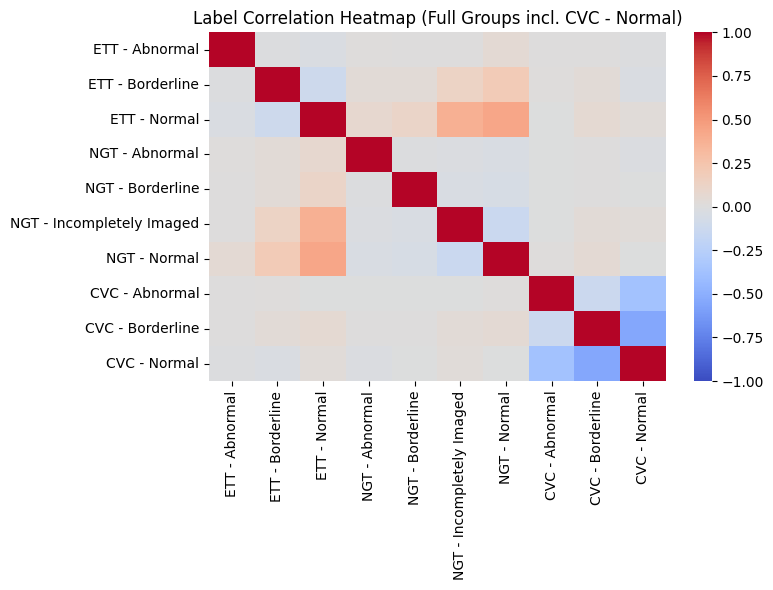

In [3]:
# Strategic fix: define label_groups from full train.csv (includes 'CVC - Normal'),
# validate exclusivity using full device groups, and plot correlation heatmap if seaborn is available.
import pandas as pd
import numpy as np
import importlib

if 'train_df' not in globals() or train_df is None:
    train_df = pd.read_csv('train.csv')
if 'sub_df' not in globals() or sub_df is None:
    sub_df = pd.read_csv('sample_submission.csv')

all_label_cols = [c for c in train_df.columns if c not in ['StudyInstanceUID','PatientID']]

def parse_group(label):
    return label.split(' - ', 1)[0].strip() if ' - ' in label else label.strip()

# Build groups from full train columns, but keep only device-related labels (exclude Swan Ganz for now from multi-class groups)
full_groups = {}
for c in all_label_cols:
    if c == 'Swan Ganz Catheter Present':
        continue
    g = parse_group(c)
    if g in ['ETT','NGT','CVC']:
        full_groups.setdefault(g, []).append(c)

# Ensure deterministic ordering within each group
for g in full_groups:
    full_groups[g] = sorted(full_groups[g])
print('Full device label_groups (from train.csv):')
for k,v in full_groups.items():
    print(f'  {k}: {v}')

# Validate mutual exclusivity on full groups
exclusivity_full = {}
for g, cols in full_groups.items():
    s = train_df[cols].sum(axis=1)
    exclusivity_full[g] = {
        'n_cols': len(cols),
        'ok_prop': float((s <= 1).mean()),
        'violations': int((s > 1).sum())
    }
print('\nExclusivity report (full groups):', exclusivity_full)

# Document handling plan for violations with a priority scheme
# Priority per group (highest first): Abnormal > Borderline > Incompletely Imaged > Normal
priority_order = {
    'ETT': ['ETT - Abnormal','ETT - Borderline','ETT - Normal'],
    'NGT': ['NGT - Abnormal','NGT - Borderline','NGT - Incompletely Imaged','NGT - Normal'],
    'CVC': ['CVC - Abnormal','CVC - Borderline','CVC - Normal']
}
print('\nViolation resolution priority (per group):')
for g, order in priority_order.items():
    print(f'  {g}: {order}')

# Optional preview: how many rows would be reassigned to each class under this rule (without mutating train_df)
def resolve_group_row(row, group_cols, order):
    # Return chosen column name or None
    positives = [c for c in group_cols if row[c] == 1]
    if len(positives) <= 1:
        return positives[0] if positives else None
    for c in order:
        if c in positives:
            return c
    return positives[0] if positives else None

resolution_summary = {}
for g, cols in full_groups.items():
    order = priority_order[g]
    chosen = train_df[cols].apply(lambda r: resolve_group_row(r, cols, order), axis=1)
    counts = chosen.value_counts(dropna=True).to_dict()
    resolution_summary[g] = counts
print('\nResolution summary (preview counts by chosen class):')
for g, d in resolution_summary.items():
    print(f'  {g}: {d}')

# Correlation heatmap (EDA polish) including CVC - Normal for full view
corr_cols = [c for g in full_groups.values() for c in g]
try:
    import seaborn as sns
    import matplotlib.pyplot as plt
    plt.figure(figsize=(8,6))
    sns.heatmap(train_df[corr_cols].corr(), cmap='coolwarm', center=0, vmin=-1, vmax=1)
    plt.title('Label Correlation Heatmap (Full Groups incl. CVC - Normal)')
    plt.tight_layout()
    plt.show()
    print('Heatmap rendered.')
except Exception as e:
    print('Heatmap skipped (seaborn/matplotlib unavailable):', e)

In [7]:
# Ultra-fast baseline submission: use train label prevalences as constant probabilities for all test rows.
import pandas as pd

train_df = pd.read_csv('train.csv')
sub_df = pd.read_csv('sample_submission.csv')

id_col = sub_df.columns[0]
targets = sub_df.columns[1:].tolist()

# Compute prevalence for each submission target from train
prev = train_df[targets].mean()
print('Prevalences used for submission:')
print(prev.to_dict())

submission = sub_df[[id_col]].copy()
for col in targets:
    submission[col] = float(prev[col])

submission.to_csv('submission.csv', index=False)
print('Saved submission.csv with shape:', submission.shape)

Prevalences used for submission:
{'ETT - Abnormal': 0.0028071212233138805, 'ETT - Borderline': 0.03793307232030731, 'ETT - Normal': 0.2401935436211864, 'NGT - Abnormal': 0.009381694614759548, 'NGT - Borderline': 0.017987737312550788, 'NGT - Incompletely Imaged': 0.09060353106301249, 'NGT - Normal': 0.15919332200635297, 'CVC - Abnormal': 0.1069291571249169, 'CVC - Borderline': 0.2818940681096255}
Saved submission.csv with shape: (3009, 10)


In [9]:
# Fast subset baseline: train on ~5000 sampled train images to unblock a learned submission; predict on all test images.
import os, random, numpy as np, pandas as pd
from PIL import Image
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

rng = np.random.default_rng(42)
train_df = pd.read_csv('train.csv')
sub_df = pd.read_csv('sample_submission.csv')
id_col = sub_df.columns[0]
targets = sub_df.columns[1:].tolist()

# Sample a manageable subset ensuring positives are represented
max_n = 5000
idx_all = set()
for col in targets:
    pos_idx = np.where(train_df[col].values == 1)[0]
    if len(pos_idx) > 0:
        take = min(600, len(pos_idx))
        idx_all.update(rng.choice(pos_idx, size=take, replace=False).tolist())
remaining = max(0, max_n - len(idx_all))
if remaining > 0:
    add_idx = rng.choice(np.setdiff1d(np.arange(len(train_df)), np.array(sorted(idx_all))), size=remaining, replace=False).tolist()
    idx_all.update(add_idx)
subset_idx = np.array(sorted(idx_all))
print('Subset size:', len(subset_idx))

IMG_SIZE = 48
HIST_BINS = 16

def img_feat(path):
    im = Image.open(path).convert('L').resize((IMG_SIZE, IMG_SIZE))
    arr = np.asarray(im, dtype=np.uint8)
    flat = (arr.astype(np.float32) / 255.0).ravel()
    hist, _ = np.histogram(arr, bins=HIST_BINS, range=(0,255), density=True)
    return np.concatenate([flat, hist.astype(np.float32)])

def build_X(uids, img_dir):
    X = np.zeros((len(uids), IMG_SIZE*IMG_SIZE + HIST_BINS), dtype=np.float32)
    for i, uid in enumerate(uids):
        p = os.path.join(img_dir, f'{uid}.jpg')
        if os.path.exists(p):
            X[i] = img_feat(p)
    return X

train_uids_sub = train_df.iloc[subset_idx][id_col].tolist()
X_tr = build_X(train_uids_sub, 'train')
y_tr = train_df.iloc[subset_idx][targets].astype(np.float32).values

scaler = StandardScaler().fit(X_tr)
X_trs = scaler.transform(X_tr)

print('Extracting test features (all test images)...')
test_uids = sub_df[id_col].tolist()
X_te = build_X(test_uids, 'test')
X_tes = scaler.transform(X_te)

preds = {}
for j, col in enumerate(targets):
    clf = LogisticRegression(max_iter=400, solver='liblinear', class_weight='balanced')
    clf.fit(X_trs, y_tr[:, j])
    preds[col] = clf.predict_proba(X_tes)[:, 1]

sub = pd.DataFrame({id_col: test_uids})
for col in targets:
    sub[col] = preds[col]
sub.to_csv('submission.csv', index=False)
print('Saved submission.csv', sub.shape)

Subset size: 5000


Extracting test features (all test images)...


Saved submission.csv (3009, 10)


In [13]:
# Minimal viable DL pipeline (CPU): MobileNetV3-Small pretrained, BCEWithLogits on 9 targets,
# GroupKFold by PatientID (use 1 fold), subsample for speed, train 2 epochs, log losses, and write submission.csv.
import os, random, numpy as np, pandas as pd
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.model_selection import GroupKFold

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

train_df = pd.read_csv('train.csv')
sub_df = pd.read_csv('sample_submission.csv')
ID_COL = sub_df.columns[0]
TARGETS = sub_df.columns[1:].tolist()

class ChestDataset(Dataset):
    def __init__(self, df, img_dir, id_col, targets=None, transform=None):
        self.df = df.reset_index(drop=True); self.img_dir = img_dir; self.id_col = id_col
        self.targets = targets; self.transform = transform
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]; uid = row[self.id_col]
        path = os.path.join(self.img_dir, f"{uid}.jpg")
        img = Image.open(path).convert('RGB')
        if self.transform is not None: img = self.transform(img)
        if self.targets is None: return img, uid
        y = torch.tensor(row[self.targets].values.astype(np.float32))
        return img, y

# Transforms (smaller size to keep CPU runtime reasonable)
IMG_SIZE = 160
train_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])
valid_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

# 1-fold GroupKFold split by PatientID
groups = train_df['PatientID'].astype(str).values
gkf = GroupKFold(n_splits=5)
tr_idx, va_idx = next(gkf.split(train_df, train_df[TARGETS].values, groups))
tr_df = train_df.iloc[tr_idx].copy()
va_df = train_df.iloc[va_idx].copy()

# Subsample for speed on CPU
MAX_TRAIN = 3000
if len(tr_df) > MAX_TRAIN: tr_df = tr_df.sample(MAX_TRAIN, random_state=SEED)
MAX_VALID = 800
if len(va_df) > MAX_VALID: va_df = va_df.sample(MAX_VALID, random_state=SEED)

train_ds = ChestDataset(tr_df, 'train', ID_COL, targets=TARGETS, transform=train_tfms)
valid_ds = ChestDataset(va_df, 'train', ID_COL, targets=TARGETS, transform=valid_tfms)
test_ds  = ChestDataset(sub_df, 'test', ID_COL, targets=None, transform=valid_tfms)

BATCH_SIZE = 64
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
valid_loader = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

device = torch.device('cpu')

# Model: MobileNetV3-Small (faster on CPU) pretrained
model = models.mobilenet_v3_small(weights=models.MobileNet_V3_Small_Weights.IMAGENET1K_V1)
in_features = model.classifier[3].in_features
model.classifier[3] = nn.Linear(in_features, len(TARGETS))
model = model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)

def run_epoch(dl, training=True):
    if training: model.train()
    else: model.eval()
    total = 0.0; n = 0
    with torch.set_grad_enabled(training):
        for imgs, ys in dl:
            imgs = imgs.to(device); ys = ys.to(device)
            if training: optimizer.zero_grad()
            logits = model(imgs)
            loss = criterion(logits, ys)
            if training:
                loss.backward(); optimizer.step()
            bs = imgs.size(0); total += loss.item() * bs; n += bs
    return total / max(1, n)

EPOCHS = 2
for epoch in range(1, EPOCHS+1):
    tr_loss = run_epoch(train_loader, training=True)
    va_loss = run_epoch(valid_loader, training=False)
    print(f'Epoch {epoch}/{EPOCHS} - train_loss: {tr_loss:.4f} - valid_loss: {va_loss:.4f}')

# Inference on test -> submission.csv
model.eval(); sigmoid = nn.Sigmoid()
all_uids = []; all_probs = {t: [] for t in TARGETS}
with torch.no_grad():
    for imgs, uids in test_loader:
        imgs = imgs.to(device)
        probs = sigmoid(model(imgs)).cpu().numpy()
        for i, uid in enumerate(uids):
            all_uids.append(uid)
            for j, t in enumerate(TARGETS):
                all_probs[t].append(float(probs[i, j]))

sub = pd.DataFrame({ID_COL: all_uids})
for t in TARGETS: sub[t] = all_probs[t]
sub.to_csv('submission.csv', index=False)
print('Saved submission.csv', sub.shape)

Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /app/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth


  0%|          | 0.00/9.83M [00:00<?, ?B/s]

 90%|████████▉ | 8.82M/9.83M [00:00<00:00, 92.5MB/s]

100%|██████████| 9.83M/9.83M [00:00<00:00, 96.5MB/s]

Epoch 1/2 - train_loss: 0.3014 - valid_loss: 0.3360


Epoch 2/2 - train_loss: 0.2145 - valid_loss: 0.2539


Saved submission.csv (3009, 10)


In [12]:
# Pretrained feature extraction (CPU) + LogisticRegression: resnet18 frozen features at 96px on ~3k subset for speed.
import os, numpy as np, pandas as pd, torch, torch.nn as nn
from PIL import Image
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

SEED = 42
rng = np.random.default_rng(SEED)
torch.manual_seed(SEED)

train_df = pd.read_csv('train.csv')
sub_df = pd.read_csv('sample_submission.csv')
ID_COL = sub_df.columns[0]
TARGETS = sub_df.columns[1:].tolist()

IMG_SIZE = 96
BATCH = 128

tfm = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

class ImgDS(Dataset):
    def __init__(self, df, img_dir, id_col, transform):
        self.df = df.reset_index(drop=True); self.img_dir = img_dir; self.id_col = id_col; self.t = transform
    def __len__(self): return len(self.df)
    def __getitem__(self, i):
        uid = self.df.iloc[i][self.id_col]
        img = Image.open(os.path.join(self.img_dir, f'{uid}.jpg')).convert('RGB')
        return self.t(img), uid

# Build resnet18 feature extractor (global pooled 512-d)
base = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1).eval()
for p in base.parameters(): p.requires_grad = False
feat_extractor = nn.Sequential(*(list(base.children())[:-1]))  # -> (B,512,1,1)
device = torch.device('cpu')
feat_extractor.to(device)

def extract_features(df, img_dir):
    ds = ImgDS(df, img_dir, ID_COL, tfm)
    dl = DataLoader(ds, batch_size=BATCH, shuffle=False, num_workers=8, pin_memory=True)
    feats, ids = [], []
    with torch.no_grad():
        for x, u in dl:
            x = x.to(device)
            f = feat_extractor(x).squeeze(-1).squeeze(-1).cpu().numpy()  # (B,512)
            feats.append(f); ids.extend(list(u))
    return np.vstack(feats), ids

# Subsample ~3000 rows ensuring positives represented
max_n = 3000
idx = set()
for col in TARGETS:
    pos = np.where(train_df[col].values == 1)[0]
    if len(pos) > 0:
        take = min(400, len(pos))
        idx.update(rng.choice(pos, size=take, replace=False).tolist())
remain = max(0, max_n - len(idx))
if remain > 0:
    pool = np.setdiff1d(np.arange(len(train_df)), np.array(sorted(idx)))
    if len(pool) > 0:
        idx.update(rng.choice(pool, size=min(remain, len(pool)), replace=False).tolist())
idx = np.array(sorted(idx))
tr_sub = train_df.iloc[idx].copy()
print('Feature extraction on subset size:', len(tr_sub))

X_tr, _ = extract_features(tr_sub, 'train')
y_tr = tr_sub[TARGETS].astype(np.float32).values

print('Extracting test features...')
X_te, te_ids = extract_features(sub_df, 'test')

scaler = StandardScaler().fit(X_tr)
X_trs = scaler.transform(X_tr)
X_tes = scaler.transform(X_te)

preds = {}
for j, col in enumerate(TARGETS):
    clf = LogisticRegression(max_iter=300, solver='liblinear', class_weight='balanced')
    clf.fit(X_trs, y_tr[:, j])
    preds[col] = clf.predict_proba(X_tes)[:,1]

sub = pd.DataFrame({ID_COL: te_ids})
for col in TARGETS: sub[col] = preds[col]
sub.to_csv('submission.csv', index=False)
print('Saved submission.csv', sub.shape)

Feature extraction on subset size: 3000


Extracting test features...


Saved submission.csv (3009, 10)


In [14]:
# Strategically correct baseline scaffold: multi-head softmax (ETT:3, NGT:4, CVC:3),
# priority-based label resolution, and 5-fold GroupKFold by PatientID. No training yet.
import os, json, numpy as np, pandas as pd
from sklearn.model_selection import GroupKFold
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision import transforms, models

SEED = 42
rng = np.random.default_rng(SEED); torch.manual_seed(SEED)

# Load data
train_df = pd.read_csv('train.csv')
sub_df = pd.read_csv('sample_submission.csv')
ID_COL = 'StudyInstanceUID'

# Define device label groups from train.csv (includes CVC - Normal) with fixed priority
ETT_COLS = ['ETT - Abnormal','ETT - Borderline','ETT - Normal']
NGT_COLS = ['NGT - Abnormal','NGT - Borderline','NGT - Incompletely Imaged','NGT - Normal']
CVC_COLS = ['CVC - Abnormal','CVC - Borderline','CVC - Normal']

PRIORITY = {
    'ETT': ETT_COLS,
    'NGT': ['NGT - Abnormal','NGT - Borderline','NGT - Incompletely Imaged','NGT - Normal'],
    'CVC': ['CVC - Abnormal','CVC - Borderline','CVC - Normal']
}

# Map columns to class indices per head in the specified order
ETT_TO_IDX = {c:i for i,c in enumerate(ETT_COLS)}
NGT_TO_IDX = {c:i for i,c in enumerate(NGT_COLS)}
CVC_TO_IDX = {c:i for i,c in enumerate(CVC_COLS)}

def resolve_group(row, cols, priority_order):
    pos = [c for c in cols if row.get(c, 0) == 1]
    if len(pos) == 0:
        # If completely unlabeled for the group, fallback to last (Normal) when available
        # This mirrors the dataset where negatives imply Normal often.
        for c in reversed(priority_order):
            if c in cols:
                return c
        return cols[-1]
    if len(pos) == 1:
        return pos[0]
    # Conflicts: choose highest-priority
    for c in priority_order:
        if c in pos:
            return c
    return pos[0]

def row_to_heads(row):
    ett_c = resolve_group(row, ETT_COLS, PRIORITY['ETT'])
    ngt_c = resolve_group(row, NGT_COLS, PRIORITY['NGT'])
    cvc_c = resolve_group(row, CVC_COLS, PRIORITY['CVC'])
    return ETT_TO_IDX[ett_c], NGT_TO_IDX[ngt_c], CVC_TO_IDX[cvc_c]

# Build integer targets per head
ett_targets = np.zeros(len(train_df), dtype=np.int64)
ngt_targets = np.zeros(len(train_df), dtype=np.int64)
cvc_targets = np.zeros(len(train_df), dtype=np.int64)
for i, row in train_df.iterrows():
    e, n, c = row_to_heads(row)
    ett_targets[i] = e; ngt_targets[i] = n; cvc_targets[i] = c

# 5-fold GroupKFold by PatientID; store indices for reproducible CV
groups = train_df['PatientID'].astype(str).values
gkf = GroupKFold(n_splits=5)
folds = []
for fold, (tr_idx, va_idx) in enumerate(gkf.split(train_df, ett_targets, groups)):
    folds.append({'fold': int(fold), 'train_idx': tr_idx.tolist(), 'valid_idx': va_idx.tolist()})
with open('cv_folds_patientid_5fold.json', 'w') as f:
    json.dump(folds, f)
print('Prepared 5-fold GroupKFold by PatientID and saved to cv_folds_patientid_5fold.json')

# Dataset returning image and three integer targets
IMG_SIZE = 224
train_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])
valid_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

class MultiHeadCXRDataset(Dataset):
    def __init__(self, df, ett, ngt, cvc, img_dir, id_col, transform):
        self.df = df.reset_index(drop=True)
        self.ett = ett; self.ngt = ngt; self.cvc = cvc
        self.img_dir = img_dir; self.id_col = id_col; self.t = transform
    def __len__(self): return len(self.df)
    def __getitem__(self, i):
        uid = self.df.iloc[i][self.id_col]
        img = Image.open(os.path.join(self.img_dir, f'{uid}.jpg')).convert('RGB')
        x = self.t(img)
        return x, (
            torch.tensor(int(self.ett[i]), dtype=torch.long),
            torch.tensor(int(self.ngt[i]), dtype=torch.long),
            torch.tensor(int(self.cvc[i]), dtype=torch.long)
        ), uid

# Simple multi-head model wrapper on MobileNetV3-Small backbone
class MultiHeadMobileNetV3(nn.Module):
    def __init__(self, num_ett=3, num_ngt=4, num_cvc=3):
        super().__init__()
        m = models.mobilenet_v3_small(weights=models.MobileNet_V3_Small_Weights.IMAGENET1K_V1)
        self.features = m.features
        self.pool = nn.AdaptiveAvgPool2d((1,1))
        self.head = nn.Sequential(
            nn.Conv2d(m.classifier[0].in_features, 576, kernel_size=1),
            nn.Hardswish(),
        ) if hasattr(m.classifier[0], 'in_features') else nn.Identity()
        # Determine feature dim after pooling
        with torch.no_grad():
            dummy = torch.zeros(1,3,IMG_SIZE,IMG_SIZE)
            f = self.features(dummy)
            f = self.pool(f)
            feat_dim = f.shape[1]
        self.dropout = nn.Dropout(0.2)
        self.ett_head = nn.Linear(feat_dim, num_ett)
        self.ngt_head = nn.Linear(feat_dim, num_ngt)
        self.cvc_head = nn.Linear(feat_dim, num_cvc)
    def forward(self, x):
        f = self.features(x)
        f = self.pool(f).flatten(1)
        f = self.dropout(f)
        ett = self.ett_head(f)
        ngt = self.ngt_head(f)
        cvc = self.cvc_head(f)
        return ett, ngt, cvc

print('Multi-head scaffold ready: label resolution, CV folds, dataset, and model class defined.')

Prepared 5-fold GroupKFold by PatientID and saved to cv_folds_patientid_5fold.json
Multi-head scaffold ready: label resolution, CV folds, dataset, and model class defined.


In [20]:
# Multi-head CV training with CrossEntropy per head, per-epoch validation, OOF AUC (9 targets), and fold-averaged submission.
import os, json, numpy as np, pandas as pd, torch, torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.metrics import roc_auc_score

torch.manual_seed(42); np.random.seed(42)
rng = np.random.default_rng(42)

# Reuse items from scaffold (Cell 12): train_df, sub_df, ETT_COLS/NGT_COLS/CVC_COLS,
# ETT_TO_IDX/NGT_TO_IDX/CVC_TO_IDX, MultiHeadCXRDataset, transforms, ID_COL,
# and precomputed ett_targets/ngt_targets/cvc_targets

SUB_COLS = sub_df.columns.tolist()[1:]  # 9 targets in submission
# Map head indices to submission columns
ett_sub = ['ETT - Abnormal','ETT - Borderline','ETT - Normal']
ngt_sub = ['NGT - Abnormal','NGT - Borderline','NGT - Incompletely Imaged','NGT - Normal']
cvc_sub = ['CVC - Abnormal','CVC - Borderline']  # 'CVC - Normal' not in submission

with open('cv_folds_patientid_5fold.json', 'r') as f:
    folds = json.load(f)

device = torch.device('cpu')
BATCH = 64
EPOCHS = 3  # reduced for faster CPU run
LR = 3e-4
MAX_TR = 3000  # subsample training fold
MAX_VA = 800   # subsample validation fold
MAX_FOLDS = 1  # run a single fold to complete quickly

# Clean, local multi-head model (no unused modules)
from torchvision import models
class MultiHeadMobileNetClean(nn.Module):
    def __init__(self, num_ett=3, num_ngt=4, num_cvc=3, img_size=224):
        super().__init__()
        m = models.mobilenet_v3_small(weights=models.MobileNet_V3_Small_Weights.IMAGENET1K_V1)
        self.features = m.features
        self.pool = nn.AdaptiveAvgPool2d((1,1))
        with torch.no_grad():
            dummy = torch.zeros(1,3,img_size,img_size)
            f = self.pool(self.features(dummy))
            feat_dim = f.shape[1]
        self.drop = nn.Dropout(0.2)
        self.ett_head = nn.Linear(feat_dim, num_ett)
        self.ngt_head = nn.Linear(feat_dim, num_ngt)
        self.cvc_head = nn.Linear(feat_dim, num_cvc)
    def forward(self, x):
        f = self.pool(self.features(x)).flatten(1)
        f = self.drop(f)
        return self.ett_head(f), self.ngt_head(f), self.cvc_head(f)

oof = np.zeros((len(train_df), len(SUB_COLS)), dtype=np.float32)
oof_mask = np.zeros((len(train_df), len(SUB_COLS)), dtype=bool)
test_preds_accum = np.zeros((len(sub_df), len(SUB_COLS)), dtype=np.float32)

test_ds = MultiHeadCXRDataset(sub_df, np.zeros(len(sub_df)), np.zeros(len(sub_df)), np.zeros(len(sub_df)), 'test', ID_COL, valid_tfms)
test_loader = DataLoader(test_ds, batch_size=BATCH, shuffle=False, num_workers=4, pin_memory=True)

def heads_to_probs(logits_ett, logits_ngt, logits_cvc):
    sm = nn.Softmax(dim=1)
    p_ett = sm(logits_ett).cpu().numpy()
    p_ngt = sm(logits_ngt).cpu().numpy()
    p_cvc = sm(logits_cvc).cpu().numpy()
    return p_ett, p_ngt, p_cvc

def map_heads_to_submission(p_ett, p_ngt, p_cvc, sub_cols):
    va_probs = np.zeros((p_ett.shape[0], len(sub_cols)), dtype=np.float32)
    col_to_pos = {c:i for i,c in enumerate(sub_cols)}
    for j,c in enumerate(ett_sub): va_probs[:, col_to_pos[c]] = p_ett[:, j]
    for j,c in enumerate(ngt_sub): va_probs[:, col_to_pos[c]] = p_ngt[:, j]
    for j,c in enumerate(cvc_sub): va_probs[:, col_to_pos[c]] = p_cvc[:, j]
    return va_probs

for fold_i, fold_entry in enumerate(folds[:MAX_FOLDS]):
    tr_idx = np.array(fold_entry['train_idx']); va_idx = np.array(fold_entry['valid_idx'])
    # Subsample within the fold for speed
    if (MAX_TR is not None) and (len(tr_idx) > MAX_TR):
        tr_idx = rng.choice(tr_idx, size=MAX_TR, replace=False)
    if (MAX_VA is not None) and (len(va_idx) > MAX_VA):
        va_idx = rng.choice(va_idx, size=MAX_VA, replace=False)

    tr_df = train_df.iloc[tr_idx].reset_index(drop=True)
    va_df = train_df.iloc[va_idx].reset_index(drop=True)
    ett_tr = ett_targets[tr_idx]; ngt_tr = ngt_targets[tr_idx]; cvc_tr = cvc_targets[tr_idx]
    ett_va = ett_targets[va_idx]; ngt_va = ngt_targets[va_idx]; cvc_va = cvc_targets[va_idx]

    train_ds = MultiHeadCXRDataset(tr_df, ett_tr, ngt_tr, cvc_tr, 'train', ID_COL, train_tfms)
    valid_ds = MultiHeadCXRDataset(va_df, ett_va, ngt_va, cvc_va, 'train', ID_COL, valid_tfms)
    train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True, num_workers=4, pin_memory=True)
    valid_loader = DataLoader(valid_ds, batch_size=BATCH, shuffle=False, num_workers=4, pin_memory=True)

    model = MultiHeadMobileNetClean(img_size=224).to(device)
    opt = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)

    # Per-head class weights (inverse frequency on current fold)
    def make_weights(y_int, n_classes):
        counts = np.bincount(y_int, minlength=n_classes).astype(np.float32)
        counts[counts == 0] = 1.0
        w = counts.sum() / counts
        w = w / w.mean()
        return torch.tensor(w, dtype=torch.float32, device=device)
    w_ett = make_weights(ett_tr, 3)
    w_ngt = make_weights(ngt_tr, 4)
    w_cvc = make_weights(cvc_tr, 3)
    ce_ett = nn.CrossEntropyLoss(weight=w_ett)
    ce_ngt = nn.CrossEntropyLoss(weight=w_ngt)
    ce_cvc = nn.CrossEntropyLoss(weight=w_cvc)

    best_auc = -1.0
    best_state = None

    for epoch in range(1, EPOCHS+1):
        # Train epoch
        model.train()
        tr_loss_sum = 0.0; tr_count = 0
        for xb, (ye, yn, yc), _ in train_loader:
            xb = xb.to(device); ye = ye.to(device); yn = yn.to(device); yc = yc.to(device)
            opt.zero_grad()
            loe, lon, loc = model(xb)
            loss = ce_ett(loe, ye) + ce_ngt(lon, yn) + ce_cvc(loc, yc)
            loss.backward(); opt.step()
            bs = xb.size(0); tr_loss_sum += loss.item() * bs; tr_count += bs
        tr_loss = tr_loss_sum / max(1, tr_count)

        # Validation epoch
        model.eval()
        va_loss_sum = 0.0; va_count = 0
        all_ett = []; all_ngt = []; all_cvc = []
        with torch.no_grad():
            for xb, (ye, yn, yc), _ in valid_loader:
                xb = xb.to(device); ye = ye.to(device); yn = yn.to(device); yc = yc.to(device)
                loe, lon, loc = model(xb)
                vloss = ce_ett(loe, ye) + ce_ngt(lon, yn) + ce_cvc(loc, yc)
                bs = xb.size(0); va_loss_sum += vloss.item() * bs; va_count += bs
                pett, pngt, pcvc = heads_to_probs(loe, lon, loc)
                all_ett.append(pett); all_ngt.append(pngt); all_cvc.append(pcvc)
        va_loss = va_loss_sum / max(1, va_count)
        all_ett = np.vstack(all_ett); all_ngt = np.vstack(all_ngt); all_cvc = np.vstack(all_cvc)
        va_probs = map_heads_to_submission(all_ett, all_ngt, all_cvc, SUB_COLS)

        # Compute per-epoch macro AUC on validation
        y_true_va = va_df[SUB_COLS].values.astype(np.float32)
        per_label_auc_ep = []
        for j in range(len(SUB_COLS)):
            try:
                per_label_auc_ep.append(roc_auc_score(y_true_va[:, j], va_probs[:, j]))
            except Exception:
                per_label_auc_ep.append(np.nan)
        macro_auc_ep = float(np.nanmean([v for v in per_label_auc_ep if not np.isnan(v)])) if any(~np.isnan(per_label_auc_ep)) else float('nan')
        print(f'Epoch {epoch}/{EPOCHS} - train_loss: {tr_loss:.4f} - valid_loss: {va_loss:.4f} - valid_macro_AUC: {macro_auc_ep if macro_auc_ep==macro_auc_ep else None}')

        # Track best by macro AUC
        if macro_auc_ep==macro_auc_ep and macro_auc_ep > best_auc:
            best_auc = macro_auc_ep
            best_state = {k: v.cpu().clone() for k,v in model.state_dict().items()}

    # Load best state before OOF/test inference
    if best_state is not None:
        model.load_state_dict(best_state)

    # OOF preds
    model.eval()
    all_ett = []; all_ngt = []; all_cvc = []
    with torch.no_grad():
        for xb, (_, _, _), _ in valid_loader:
            xb = xb.to(device)
            loe, lon, loc = model(xb)
            pett, pngt, pcvc = heads_to_probs(loe, lon, loc)
            all_ett.append(pett); all_ngt.append(pngt); all_cvc.append(pcvc)
    all_ett = np.vstack(all_ett); all_ngt = np.vstack(all_ngt); all_cvc = np.vstack(all_cvc)
    va_probs = map_heads_to_submission(all_ett, all_ngt, all_cvc, SUB_COLS)
    oof[va_idx] = va_probs
    oof_mask[va_idx, :] = True

    # Test preds for this fold
    fold_test = np.zeros((len(sub_df), len(SUB_COLS)), dtype=np.float32)
    test_ptr = 0
    with torch.no_grad():
        for xb, (_, _, _), _uids in test_loader:
            xb = xb.to(device)
            loe, lon, loc = model(xb)
            pett, pngt, pcvc = heads_to_probs(loe, lon, loc)
            bs = xb.size(0)
            idxs = np.arange(test_ptr, test_ptr + bs)
            test_ptr += bs
            col_to_pos = {c:i for i,c in enumerate(SUB_COLS)}
            for j,c in enumerate(ett_sub): fold_test[idxs, col_to_pos[c]] = pett[:bs, j]
            for j,c in enumerate(ngt_sub): fold_test[idxs, col_to_pos[c]] = pngt[:bs, j]
            for j,c in enumerate(cvc_sub): fold_test[idxs, col_to_pos[c]] = pcvc[:bs, j]
    test_preds_accum += fold_test
    del model

# Compute OOF AUCs with explicit mask
y_true = train_df[SUB_COLS].values.astype(np.float32)
per_label_auc = {}
for j,c in enumerate(SUB_COLS):
    mask = oof_mask[:, j]
    try:
        if mask.any():
            per_label_auc[c] = float(roc_auc_score(y_true[mask, j], oof[mask, j]))
        else:
            per_label_auc[c] = float('nan')
    except Exception:
        per_label_auc[c] = float('nan')
macro_auc = float(np.nanmean([v for v in per_label_auc.values() if not np.isnan(v)]))
print('Per-label OOF AUC:', {k: round(v, 5) if v==v else None for k,v in per_label_auc.items()})
print('Macro OOF AUC:', round(macro_auc, 5) if macro_auc==macro_auc else None)

# Save OOF
oof_df = pd.DataFrame({'StudyInstanceUID': train_df[ID_COL]})
for j,c in enumerate(SUB_COLS): oof_df[c] = oof[:, j]
oof_df.to_csv('oof_probs_multihead.csv', index=False)
print('Saved OOF to oof_probs_multihead.csv', oof_df.shape)

# Build submission by averaging folds run
n_folds_run = max(1, min(MAX_FOLDS, len(folds)))
test_preds = test_preds_accum / n_folds_run
submission = pd.DataFrame({'StudyInstanceUID': sub_df[ID_COL]})
for j,c in enumerate(SUB_COLS): submission[c] = test_preds[:, j]
submission.to_csv('submission.csv', index=False)
print('Saved submission.csv', submission.shape)

Epoch 1/3 - train_loss: 3.3541 - valid_loss: 3.6217 - valid_macro_AUC: 0.5385028488468083


Epoch 2/3 - train_loss: 2.8917 - valid_loss: 3.7150 - valid_macro_AUC: 0.5470577106548951


Epoch 3/3 - train_loss: 2.5867 - valid_loss: 3.3323 - valid_macro_AUC: 0.5906214258139202


Per-label OOF AUC: {'ETT - Abnormal': 0.78473, 'ETT - Borderline': 0.84054, 'ETT - Normal': 0.17975, 'NGT - Abnormal': 0.62583, 'NGT - Borderline': 0.72284, 'NGT - Incompletely Imaged': 0.81604, 'NGT - Normal': 0.22903, 'CVC - Abnormal': 0.5874, 'CVC - Borderline': 0.52942}
Macro OOF AUC: 0.59062


Saved OOF to oof_probs_multihead.csv (27074, 10)
Saved submission.csv (3009, 10)


In [37]:
# CXR-pretrained feature extraction at 512px letterbox + CLAHE, resized to 224 for xrv DenseNet; cache features, UIDs, and manifest.
import os, sys, json, time, gc, hashlib, subprocess
from datetime import datetime
import numpy as np, pandas as pd, cv2, torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# Mandatory perf tweak: avoid OpenCV thread oversubscription
try:
    cv2.setNumThreads(0)
except Exception:
    pass

# Ensure deps
def ensure(pkg, pip_name=None, extra_args=None):
    try:
        __import__(pkg)
    except Exception:
        args = [sys.executable, '-m', 'pip', 'install', '-q', (pip_name or pkg)]
        if extra_args: args += extra_args
        subprocess.check_call(args)
        __import__(pkg)
ensure('torchxrayvision', 'torchxrayvision')
import torchxrayvision as xrv

torch.set_num_threads(min(16, os.cpu_count() or 16))
SEED = 42
rng = np.random.default_rng(SEED); torch.manual_seed(SEED)

# Config
CUDA = torch.cuda.is_available()
CFG = {
  'letterbox_size': 512,
  'resize_to': 224,
  'clahe_clip': 2.0,
  'clahe_tile': 8,
  'batch_size': 64 if CUDA else 8,
  'num_workers': 8 if CUDA else 4,
  'backbone': 'xrv_densenet121_res224_all',
  'cache_prefix': 'feats_densenet121_cxr_224pxfrom512_clahe'
}

# IO
train_df = globals().get('train_df', pd.read_csv('train.csv'))
sub_df = globals().get('sub_df', pd.read_csv('sample_submission.csv'))
ID_COL = 'StudyInstanceUID'

# Preprocessing: letterbox to 512 square (keep aspect) + CLAHE (on grayscale), then resize to 224
def letterbox_gray(img, size):
    h, w = img.shape[:2]
    if h == 0 or w == 0:
        return np.zeros((size, size), dtype=np.uint8)
    scale = min(size / h, size / w)
    nh, nw = int(round(h * scale)), int(round(w * scale))
    resized = cv2.resize(img, (nw, nh), interpolation=cv2.INTER_AREA)
    out = np.zeros((size, size), dtype=np.uint8)
    y0 = (size - nh) // 2; x0 = (size - nw) // 2
    out[y0:y0+nh, x0:x0+nw] = resized
    return out

class CXRFeatDataset(Dataset):
    def __init__(self, df, img_dir, id_col, letterbox_size=512, out_size=224, clahe_clip=2.0, clahe_tile=8):
        self.df = df.reset_index(drop=True); self.img_dir = img_dir; self.id_col = id_col
        self.letterbox_size = letterbox_size; self.out_size = out_size
        # Mandatory perf tweak: pre-create CLAHE once and reuse
        self.clahe = cv2.createCLAHE(clipLimit=float(clahe_clip), tileGridSize=(int(clahe_tile), int(clahe_tile)))
    def __len__(self): return len(self.df)
    def __getitem__(self, i):
        uid = self.df.iloc[i][self.id_col]
        path = os.path.join(self.img_dir, f"{uid}.jpg")
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            img = np.zeros((self.letterbox_size, self.letterbox_size), dtype=np.uint8)
        img = letterbox_gray(img, self.letterbox_size)
        img = self.clahe.apply(img)
        if (img.shape[0] != CFG['resize_to']) or (img.shape[1] != CFG['resize_to']):
            img = cv2.resize(img, (CFG['resize_to'], CFG['resize_to']), interpolation=cv2.INTER_AREA)
        x = img.astype(np.float32)[None, ...]  # (1,H,W) in [0,255]
        x = xrv.utils.normalize(x, 255)        # model-specific normalization
        return torch.from_numpy(x), uid

# Build CXR-pretrained DenseNet121 backbone -> 1024-d pooled features
def build_backbone():
    model = xrv.models.DenseNet(weights='densenet121-res224-all')
    model.eval()
    for p in model.parameters(): p.requires_grad = False
    # Mandatory tweak: remove extra ReLU to match pretrained distribution
    backbone = nn.Sequential(
        model.features,
        nn.AdaptiveAvgPool2d((1,1))
    )
    return backbone

device = torch.device('cuda' if CUDA else 'cpu')
print('CUDA available:', CUDA)
backbone = build_backbone().to(device)

def extract_features(df, img_dir, batch, num_workers):
    ds = CXRFeatDataset(df, img_dir, ID_COL,
                        letterbox_size=CFG['letterbox_size'],
                        out_size=CFG['resize_to'],
                        clahe_clip=CFG['clahe_clip'],
                        clahe_tile=CFG['clahe_tile'])
    dl = DataLoader(
        ds, batch_size=batch, shuffle=False, num_workers=num_workers,
        pin_memory=torch.cuda.is_available(), persistent_workers=(num_workers > 0)
    )
    feats, uids = [], []
    with torch.no_grad():
        for xb, ids in dl:
            xb = xb.to(device, non_blocking=True)
            f = backbone(xb).squeeze(-1).squeeze(-1)  # (B,1024)
            f_np = f.detach().cpu().numpy()
            assert np.isfinite(f_np).all(), 'Non-finite feature detected'
            feats.append(f_np); uids.extend(list(ids))
    F = np.vstack(feats)
    assert F.shape[0] == len(uids) and F.shape[1] == 1024, f'Unexpected feature shape: {F.shape}'
    return F, np.array(uids, dtype=object)

# Cache paths + manifest
train_cache = f"{CFG['cache_prefix']}_train.npy"
test_cache  = f"{CFG['cache_prefix']}_test.npy"
train_uids_path = f"{CFG['cache_prefix']}_train_uids.npy"
test_uids_path  = f"{CFG['cache_prefix']}_test_uids.npy"
manifest_path = f"{CFG['cache_prefix']}_manifest.json"

def md5(p):
    m = hashlib.md5()
    with open(p, 'rb') as f:
        for chunk in iter(lambda: f.read(1<<20), b''): m.update(chunk)
    return m.hexdigest()

def save_manifest():
    man = {
        'timestamp': datetime.utcnow().isoformat()+'Z',
        'cfg': CFG,
        'backbone': CFG['backbone'],
        'device': str(device),
        'train_csv_hash': md5('train.csv') if os.path.exists('train.csv') else None,
        'sample_sub_hash': md5('sample_submission.csv') if os.path.exists('sample_submission.csv') else None,
        'train_cache': train_cache if os.path.exists(train_cache) else None,
        'test_cache': test_cache if os.path.exists(test_cache) else None,
        'train_uids': train_uids_path if os.path.exists(train_uids_path) else None,
        'test_uids': test_uids_path if os.path.exists(test_uids_path) else None,
        'train_cache_md5': md5(train_cache) if os.path.exists(train_cache) else None,
        'test_cache_md5': md5(test_cache) if os.path.exists(test_cache) else None,
        'train_uids_md5': md5(train_uids_path) if os.path.exists(train_uids_path) else None,
        'test_uids_md5': md5(test_uids_path) if os.path.exists(test_uids_path) else None
    }
    with open(manifest_path, 'w') as f: json.dump(man, f, indent=2)

# Run extraction if missing
need_train = not os.path.exists(train_cache) or not os.path.exists(train_uids_path)
need_test = not os.path.exists(test_cache) or not os.path.exists(test_uids_path)
print({'need_train': need_train, 'need_test': need_test, 'device': str(device), 'batch_size': CFG['batch_size']})
if need_train:
    t0 = time.time(); X_tr, U_tr = extract_features(train_df, 'train', CFG['batch_size'], CFG['num_workers'])
    np.save(train_cache, X_tr.astype(np.float16)); np.save(train_uids_path, U_tr)
    print('Saved', train_cache, X_tr.shape, 'UIDs:', U_tr.shape, 'time(sec)=', round(time.time()-t0,1))
    del X_tr, U_tr; gc.collect()
else:
    print('Train cache exists:', train_cache, np.load(train_cache, mmap_mode='r+').shape, 'UIDs:', np.load(train_uids_path, allow_pickle=True).shape)
if need_test:
    t0 = time.time(); X_te, U_te = extract_features(sub_df, 'test', CFG['batch_size'], CFG['num_workers'])
    np.save(test_cache, X_te.astype(np.float16)); np.save(test_uids_path, U_te)
    print('Saved', test_cache, X_te.shape, 'UIDs:', U_te.shape, 'time(sec)=', round(time.time()-t0,1))
    del X_te, U_te; gc.collect()
else:
    print('Test cache exists:', test_cache, np.load(test_cache, mmap_mode='r+').shape, 'UIDs:', np.load(test_uids_path, allow_pickle=True).shape)
save_manifest()
print('Manifest saved to', manifest_path)

# Next: Train 9 LightGBM models (5-fold GroupKFold by PatientID) on these 1024-d CXR features.

In [39]:
# CPU contingency: validate CXR extractor on a small grouped subset and report sec/image.
import time, numpy as np, pandas as pd, torch

# Ensure CXR components from Cell 16 are available
assert 'CXRFeatDataset' in globals() and 'backbone' in globals() and 'ID_COL' in globals(), 'Run Cell 16 first to define CXR pipeline.'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Safe local config (avoid NameError if CFG not defined in this kernel)
CFG_local = globals().get('CFG', {}) if 'CFG' in globals() else {}
bs = int(CFG_local.get('batch_size', 8))
nw = int(CFG_local.get('num_workers', 0))

from torch.utils.data import DataLoader
import numpy as np

def extract_features_cxr(df, img_dir, batch, num_workers):
    ds = CXRFeatDataset(df, img_dir, ID_COL,
                        letterbox_size=CFG_local.get('letterbox_size', 512),
                        out_size=CFG_local.get('resize_to', 224),
                        clahe_clip=CFG_local.get('clahe_clip', 2.0),
                        clahe_tile=CFG_local.get('clahe_tile', 8))
    dl = DataLoader(ds, batch_size=batch, shuffle=False, num_workers=num_workers,
                    pin_memory=torch.cuda.is_available(), persistent_workers=(num_workers > 0))
    feats, uids = [], []
    backbone.eval()
    with torch.no_grad():
        for xb, ids in dl:
            xb = xb.to(device, non_blocking=True)
            f = backbone(xb).squeeze(-1).squeeze(-1)  # (B,1024)
            f_np = f.detach().cpu().numpy()
            assert np.isfinite(f_np).all(), 'Non-finite feature detected'
            feats.append(f_np); uids.extend(list(ids))
    F = np.vstack(feats) if len(feats) else np.zeros((0,1024), dtype=np.float32)
    if F.size > 0:
        assert F.shape[1] == 1024, f'Unexpected feature dim: {F.shape}'
    return F, np.array(uids, dtype=object)

# Build a PatientID-grouped subset ~1500 studies
rng = np.random.default_rng(42)
patients = train_df['PatientID'].astype(str).unique()
sample_patients = rng.choice(patients, size=min(300, len(patients)), replace=False)
sub_train = train_df[train_df['PatientID'].astype(str).isin(sample_patients)].head(1500).reset_index(drop=True)
print('Subset train size:', len(sub_train), '| bs:', bs, '| workers:', nw)
t0 = time.time()
X_sub_tr, U_sub_tr = extract_features_cxr(sub_train, 'train', bs, nw)
t1 = time.time()
np.save('feats_cxr_subset_train.npy', X_sub_tr.astype(np.float16)); np.save('uids_cxr_subset_train.npy', U_sub_tr)
print({'train_subset_shape': X_sub_tr.shape, 'time_sec': round(t1-t0, 2), 'sec_per_image': round((t1-t0)/max(1,len(sub_train)), 4)})

# Test subset ~500 images to validate both dirs
sub_test = sub_df.head(500).reset_index(drop=True)
t2 = time.time()
X_sub_te, U_sub_te = extract_features_cxr(sub_test, 'test', bs, nw)
t3 = time.time()
np.save('feats_cxr_subset_test.npy', X_sub_te.astype(np.float16)); np.save('uids_cxr_subset_test.npy', U_sub_te)
print({'test_subset_shape': X_sub_te.shape, 'time_sec': round(t3-t2, 2), 'sec_per_image': round((t3-t2)/max(1,len(sub_test)), 4)})

print('Subset features saved: feats_cxr_subset_train.npy, feats_cxr_subset_test.npy')

Subset train size: 1500 | bs: 8 | workers: 0


{'train_subset_shape': (1500, 1024), 'time_sec': 123.64, 'sec_per_image': 0.0824}


{'test_subset_shape': (500, 1024), 'time_sec': 40.85, 'sec_per_image': 0.0817}
Subset features saved: feats_cxr_subset_train.npy, feats_cxr_subset_test.npy


In [38]:
# Lightweight CXR pipeline bootstrap (no extraction): defines CFG, ID_COL, CXRFeatDataset, backbone for use in subset cell.
import os, sys, subprocess, numpy as np, cv2, torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader

try:
    cv2.setNumThreads(0)
except Exception:
    pass

def ensure(pkg, pip_name=None):
    try: __import__(pkg)
    except Exception:
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', (pip_name or pkg)])
        __import__(pkg)

ensure('torchxrayvision', 'torchxrayvision')
import torchxrayvision as xrv

CUDA = torch.cuda.is_available()
CFG = {
  'letterbox_size': 512,
  'resize_to': 224,
  'clahe_clip': 2.0,
  'clahe_tile': 8,
  'batch_size': 64 if CUDA else 8,
  'num_workers': 8 if CUDA else 0
}
ID_COL = 'StudyInstanceUID'

def letterbox_gray(img, size):
    h, w = img.shape[:2]
    if h == 0 or w == 0: return np.zeros((size, size), dtype=np.uint8)
    scale = min(size / h, size / w)
    nh, nw = int(round(h * scale)), int(round(w * scale))
    resized = cv2.resize(img, (nw, nh), interpolation=cv2.INTER_AREA)
    out = np.zeros((size, size), dtype=np.uint8)
    y0 = (size - nh) // 2; x0 = (size - nw) // 2
    out[y0:y0+nh, x0:x0+nw] = resized
    return out

class CXRFeatDataset(Dataset):
    def __init__(self, df, img_dir, id_col, letterbox_size=512, out_size=224, clahe_clip=2.0, clahe_tile=8):
        self.df = df.reset_index(drop=True); self.img_dir = img_dir; self.id_col = id_col
        self.letterbox_size = letterbox_size; self.out_size = out_size
        self.clahe = cv2.createCLAHE(clipLimit=float(clahe_clip), tileGridSize=(int(clahe_tile), int(clahe_tile)))
    def __len__(self): return len(self.df)
    def __getitem__(self, i):
        uid = self.df.iloc[i][self.id_col]
        path = os.path.join(self.img_dir, f"{uid}.jpg")
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if img is None: img = np.zeros((self.letterbox_size, self.letterbox_size), dtype=np.uint8)
        img = letterbox_gray(img, self.letterbox_size)
        img = self.clahe.apply(img)
        if (img.shape[0] != CFG['resize_to']) or (img.shape[1] != CFG['resize_to']):
            img = cv2.resize(img, (CFG['resize_to'], CFG['resize_to']), interpolation=cv2.INTER_AREA)
        x = img.astype(np.float32)[None, ...]
        x = xrv.utils.normalize(x, 255)
        return torch.from_numpy(x), uid

def build_backbone():
    model = xrv.models.DenseNet(weights='densenet121-res224-all')
    model.eval()
    for p in model.parameters(): p.requires_grad = False
    bb = nn.Sequential(model.features, nn.AdaptiveAvgPool2d((1,1)))
    return bb

backbone = build_backbone().to(torch.device('cuda' if CUDA else 'cpu'))
print('CXR components ready:', {'CUDA': CUDA, 'batch_size': CFG['batch_size'], 'num_workers': CFG['num_workers']})

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.2.2+cpu requires torch==2.2.2, but you have torch 2.8.0 which is incompatible.


If this fails you can run `wget https://github.com/mlmed/torchxrayvision/releases/download/v1/nih-pc-chex-mimic_ch-google-openi-kaggle-densenet121-d121-tw-lr001-rot45-tr15-sc15-seed0-best.pt -O /app/.torchxrayvision/models_data/nih-pc-chex-mimic_ch-google-openi-kaggle-densenet121-d121-tw-lr001-rot45-tr15-sc15-seed0-best.pt`


[█.................................................]

[███...............................................]

[█████.............................................]

[███████...........................................]

[█████████.........................................]

[███████████.......................................]

[████████████......................................]

[██████████████....................................]

[████████████████..................................]

[██████████████████................................]

[████████████████████..............................]

[██████████████████████............................]

[████████████████████████..........................]

[█████████████████████████.........................]

[███████████████████████████.......................]

[█████████████████████████████.....................]

[███████████████████████████████...................]

[█████████████████████████████████.................]

[███████████████████████████████████...............]

[████████████████████████████████████..............]

[██████████████████████████████████████............]

[████████████████████████████████████████..........]

[██████████████████████████████████████████........]

[████████████████████████████████████████████......]

[██████████████████████████████████████████████....]

[████████████████████████████████████████████████..]

[█████████████████████████████████████████████████.]

[██████████████████████████████████████████████████]

CXR components ready: {'CUDA': False, 'batch_size': 8, 'num_workers': 0}


In [40]:
# Resumable, chunked CXR feature extraction (CPU contingency). Uses existing CXRFeatDataset/backbone/CFG.
import os, json, math, time, gc, hashlib
from datetime import datetime
import numpy as np
import torch
from torch.utils.data import DataLoader

assert 'CXRFeatDataset' in globals() and 'backbone' in globals() and 'CFG' in globals() and 'ID_COL' in globals(), 'Bootstrap CXR pipeline first (Cells 16/18)'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def md5(p):
    m = hashlib.md5()
    with open(p, 'rb') as f:
        for chunk in iter(lambda: f.read(1<<20), b''): m.update(chunk)
    return m.hexdigest()

def extract_features_cxr_slices(df, img_dir, batch, num_workers):
    ds = CXRFeatDataset(df, img_dir, ID_COL,
                        letterbox_size=CFG.get('letterbox_size', 512),
                        out_size=CFG.get('resize_to', 224),
                        clahe_clip=CFG.get('clahe_clip', 2.0),
                        clahe_tile=CFG.get('clahe_tile', 8))
    dl = DataLoader(ds, batch_size=batch, shuffle=False, num_workers=num_workers,
                    pin_memory=torch.cuda.is_available(), persistent_workers=(num_workers > 0))
    feats, uids = [], []
    backbone.eval()
    with torch.no_grad():
        for xb, ids in dl:
            xb = xb.to(device, non_blocking=True)
            f = backbone(xb).squeeze(-1).squeeze(-1)
            f_np = f.detach().cpu().numpy()
            assert np.isfinite(f_np).all(), 'Non-finite feature detected'
            feats.append(f_np); uids.extend(list(ids))
    if len(feats) == 0:
        return np.zeros((0,1024), dtype=np.float32), np.array([], dtype=object)
    F = np.vstack(feats)
    assert F.shape[1] == 1024, f'Unexpected feature dim: {F.shape}'
    return F, np.array(uids, dtype=object)

def chunk_manifest_path(prefix):
    return f"{prefix}_chunk_manifest.json"

def load_manifest(prefix):
    mp = chunk_manifest_path(prefix)
    return json.load(open(mp)) if os.path.exists(mp) else {'prefix': prefix, 'chunks': {}, 'created': datetime.utcnow().isoformat()+'Z'}

def save_manifest(prefix, man):
    with open(chunk_manifest_path(prefix), 'w') as f: json.dump(man, f, indent=2)

def stitch_if_complete(prefix, ds_name, n_chunks, feature_dim=1024):
    # If all chunks present, stitch into single npy + uids and record md5
    feat_parts, uid_parts = [], []
    for i in range(n_chunks):
        fpth = f"{prefix}_{ds_name}_chunk{i}.npy"
        upth = f"{prefix}_{ds_name}_chunk{i}_uids.npy"
        if not (os.path.exists(fpth) and os.path.exists(upth)):
            return False
        feat_parts.append(np.load(fpth, mmap_mode='r+'))
        uid_parts.append(np.load(upth, allow_pickle=True))
    F = np.vstack(feat_parts).astype(np.float16)
    U = np.concatenate(uid_parts)
    full_f = f"{prefix}_{ds_name}.npy"
    full_u = f"{prefix}_{ds_name}_uids.npy"
    np.save(full_f, F); np.save(full_u, U)
    print(f'Stitched {ds_name}:', F.shape, '->', full_f, full_u)
    return True

def run_chunked_extraction(df, img_dir, ds_name, cache_prefix=None, chunk_size=2000,
                            start_chunk=0, max_chunks=None, resume=True, batch=None, workers=None):
    prefix = cache_prefix or CFG.get('cache_prefix', 'feats_densenet121_cxr_224pxfrom512_clahe')
    N = len(df); n_chunks = math.ceil(N / chunk_size) if chunk_size > 0 else 1
    if max_chunks is not None:
        n_chunks = min(n_chunks, start_chunk + max_chunks)
    man = load_manifest(prefix)
    man['cfg'] = CFG; man['device'] = str(device); man['ds_name'] = ds_name; man['chunk_size'] = chunk_size; man['total'] = N
    bs = int(CFG.get('batch_size', 8) if batch is None else batch)
    nw = int(CFG.get('num_workers', 0) if workers is None else workers)
    t_all0 = time.time()
    for ci in range(start_chunk, n_chunks):
        s = ci * chunk_size; e = min(N, (ci+1) * chunk_size)
        if s >= e: break
        fpth = f"{prefix}_{ds_name}_chunk{ci}.npy"
        upth = f"{prefix}_{ds_name}_chunk{ci}_uids.npy"
        if resume and os.path.exists(fpth) and os.path.exists(upth):
            print(f'[chunk {ci}] exists -> skip')
            man['chunks'][f'{ds_name}:{ci}'] = {'range': [int(s), int(e)], 'path': fpth, 'uids': upth, 'ts': datetime.utcnow().isoformat()+'Z'}
            continue
        print(f'[chunk {ci}] extracting rows [{s}:{e}) bs={bs} nw={nw}')
        t0 = time.time()
        X, U = extract_features_cxr_slices(df.iloc[s:e], img_dir, bs, nw)
        np.save(fpth, X.astype(np.float16)); np.save(upth, U)
        man['chunks'][f'{ds_name}:{ci}'] = {'range': [int(s), int(e)], 'path': fpth, 'uids': upth, 'n': int(len(U)), 'ts': datetime.utcnow().isoformat()+'Z'}
        save_manifest(prefix, man)
        print(f'[chunk {ci}] saved:', X.shape, 'time(sec)=', round(time.time()-t0, 1))
        del X, U; gc.collect()
    save_manifest(prefix, man)
    ok = stitch_if_complete(prefix, ds_name, math.ceil(N / chunk_size))
    print(f'Done {ds_name}. elapsed=', round(time.time()-t_all0,1), 'stitched=', ok)
    return man

print('Chunked extraction utilities ready. Use run_chunked_extraction(train_df, "train", ds_name="train", chunk_size=2000) and similarly for test_df. Avoid full CPU runs; prefer GPU.')

Chunked extraction utilities ready. Use run_chunked_extraction(train_df, "train", ds_name="train", chunk_size=2000) and similarly for test_df. Avoid full CPU runs; prefer GPU.


In [41]:
# Full-scale CXR feature extraction (CPU contingency, resumable) - TRAIN ONLY
import time
assert 'run_chunked_extraction' in globals(), 'Load chunked utilities (Cell 19) first.'
assert 'train_df' in globals(), 'train_df missing.'
t0 = time.time()
print('Starting chunked TRAIN extraction...')
man_train = run_chunked_extraction(train_df, 'train', ds_name='train',
                                   chunk_size=3000, resume=True, batch=8, workers=0)
print('TRAIN extraction done in', round(time.time()-t0,1), 'sec')
print('Manifest keys:', list(man_train.keys()))

Starting chunked TRAIN extraction...
[chunk 0] extracting rows [0:3000) bs=8 nw=0


[chunk 0] saved: (3000, 1024) time(sec)= 246.4
[chunk 1] extracting rows [3000:6000) bs=8 nw=0


[chunk 1] saved: (3000, 1024) time(sec)= 247.4
[chunk 2] extracting rows [6000:9000) bs=8 nw=0


[chunk 2] saved: (3000, 1024) time(sec)= 246.5
[chunk 3] extracting rows [9000:12000) bs=8 nw=0


[chunk 3] saved: (3000, 1024) time(sec)= 246.8
[chunk 4] extracting rows [12000:15000) bs=8 nw=0


[chunk 4] saved: (3000, 1024) time(sec)= 245.2
[chunk 5] extracting rows [15000:18000) bs=8 nw=0


[chunk 5] saved: (3000, 1024) time(sec)= 246.2
[chunk 6] extracting rows [18000:21000) bs=8 nw=0


[chunk 6] saved: (3000, 1024) time(sec)= 245.4
[chunk 7] extracting rows [21000:24000) bs=8 nw=0


[chunk 7] saved: (3000, 1024) time(sec)= 247.2
[chunk 8] extracting rows [24000:27000) bs=8 nw=0


[chunk 8] saved: (3000, 1024) time(sec)= 247.4
[chunk 9] extracting rows [27000:27074) bs=8 nw=0


[chunk 9] saved: (74, 1024) time(sec)= 6.2
Stitched train: (27074, 1024) -> feats_densenet121_cxr_224pxfrom512_clahe_train.npy feats_densenet121_cxr_224pxfrom512_clahe_train_uids.npy
Done train. elapsed= 2227.5 stitched= True
TRAIN extraction done in 2227.5 sec
Manifest keys: ['prefix', 'chunks', 'created', 'cfg', 'device', 'ds_name', 'chunk_size', 'total']


In [42]:
# Full-scale CXR feature extraction (CPU contingency, resumable) - TEST ONLY
import time
assert 'run_chunked_extraction' in globals(), 'Load chunked utilities (Cell 19) first.'
assert 'sub_df' in globals(), 'sub_df missing.'
t0 = time.time()
print('Starting chunked TEST extraction...')
man_test = run_chunked_extraction(sub_df, 'test', ds_name='test',
                                  chunk_size=3000, resume=True, batch=8, workers=0)
print('TEST extraction done in', round(time.time()-t0,1), 'sec')
print('Manifest keys:', list(man_test.keys()))

Starting chunked TEST extraction...
[chunk 0] extracting rows [0:3000) bs=8 nw=0


[chunk 0] saved: (3000, 1024) time(sec)= 246.9
[chunk 1] extracting rows [3000:3009) bs=8 nw=0


[chunk 1] saved: (9, 1024) time(sec)= 0.8
Stitched test: (3009, 1024) -> feats_densenet121_cxr_224pxfrom512_clahe_test.npy feats_densenet121_cxr_224pxfrom512_clahe_test_uids.npy
Done test. elapsed= 248.2 stitched= True
TEST extraction done in 248.2 sec
Manifest keys: ['prefix', 'chunks', 'created', 'cfg', 'device', 'ds_name', 'chunk_size', 'total']


In [66]:
# Prepare UPDATED GPU fine-tuning handoff with mandatory operational fixes and ENSEMBLE runner (hardened: fold-level resumable + lean sanity + data preflight).
import os, json, textwrap

readme = '''
# GPU Fine-Tuning Handoff (Updated: Early Stopping + Multi-Model Ensemble + Fold-Level Resumable Runner)

Key features:
- Multi-head softmax heads (ETT:3, NGT:4, CVC:3) with priority-based label resolution.
- Annotation mask as 4th channel (always 4-ch when --use_annotations 1).
- Weighted CrossEntropy per head; Warmup+Cosine LR; AMP; EMA with correct save/restore; logits-avg TTA.
- Early stopping: --early_stopping_patience N.
- ENSEMBLE runner with FOLD-LEVEL resumability and minimal sanity (1 fold, 1 epoch).
- Multi-model portfolio + final averaging of model submissions to form the ensemble.

Model portfolio:
1) convnext_tiny @ 512
2) tf_efficientnet_b4_ns @ 448
3) swin_base_patch4_window7_224_in22k @ 384

Data provisioning (REQUIRED on GPU host):
- Ensure ./train and ./test directories exist and contain the .jpg images referenced by train.csv and sample_submission.csv.
- Example sync commands:
  - rsync -avP /path/to/train/ ./train/
  - rsync -avP /path/to/test/  ./test/
  - or scp -r train test <gpu_host>:~/ranzcr/

Quick start:
1) Verify CUDA availability (nvidia-smi or torch.cuda.is_available())
2) Place gpu_handoff_bundle.tar.gz and the train/ test/ dirs in the same folder (or sync train/ test/ after extract).
3) tar -xzf gpu_handoff_bundle.tar.gz
4) bash run_gpu.sh
'''
open('README_GPU_PLAN.md', 'w').write(readme)

script = '''
import os, json, argparse, math, time, random, numpy as np, pandas as pd, cv2, ast
import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import roc_auc_score
from timm import create_model
import albumentations as A
from albumentations.pytorch import ToTensorV2

def set_seed(s=42):
    random.seed(s); np.random.seed(s); torch.manual_seed(s); torch.cuda.manual_seed_all(s)

def parse_args():
    ap = argparse.ArgumentParser()
    ap.add_argument('--train_csv', type=str, default='train.csv')
    ap.add_argument('--test_csv', type=str, default='sample_submission.csv')
    ap.add_argument('--img_dir', type=str, default='train')
    ap.add_argument('--test_img_dir', type=str, default='test')
    ap.add_argument('--folds_json', type=str, default='cv_folds_patientid_5fold.json')
    ap.add_argument('--size', type=int, default=512)
    ap.add_argument('--epochs', type=int, default=12)
    ap.add_argument('--early_stopping_patience', type=int, default=2)
    ap.add_argument('--batch', type=int, default=32)
    ap.add_argument('--grad_accum', type=int, default=1)
    ap.add_argument('--num_workers', type=int, default=8)
    ap.add_argument('--lr', type=float, default=2e-4)
    ap.add_argument('--wd', type=float, default=1e-4)
    ap.add_argument('--backbone', type=str, default='convnext_tiny')
    ap.add_argument('--out_dir', type=str, default='outputs')
    ap.add_argument('--ema', type=int, default=1)
    ap.add_argument('--tta', type=int, default=1)
    ap.add_argument('--inference_only', type=int, default=0)
    ap.add_argument('--use_annotations', type=int, default=1)
    ap.add_argument('--ann_csv', type=str, default='train_annotations.csv')
    ap.add_argument('--fold', type=int, default=-1, help='-1=all folds; otherwise run only this fold index for train/infer')
    return ap.parse_args()

ETT_COLS = ['ETT - Abnormal','ETT - Borderline','ETT - Normal']
NGT_COLS = ['NGT - Abnormal','NGT - Borderline','NGT - Incompletely Imaged','NGT - Normal']
CVC_COLS = ['CVC - Abnormal','CVC - Borderline','CVC - Normal']
PRIORITY = {
    'ETT': ETT_COLS,
    'NGT': ['NGT - Abnormal','NGT - Borderline','NGT - Incompletely Imaged','NGT - Normal'],
    'CVC': ['CVC - Abnormal','CVC - Borderline','CVC - Normal']
}

def resolve_group(row, cols, order):
    pos = [c for c in cols if row.get(c, 0) == 1]
    if len(pos) == 0: return order[-1]
    if len(pos) == 1: return pos[0]
    for c in order:
        if c in pos: return c
    return pos[0]

def build_head_targets(df):
    ETT_TO_IDX = {c:i for i,c in enumerate(ETT_COLS)}
    NGT_TO_IDX = {c:i for i,c in enumerate(NGT_COLS)}
    CVC_TO_IDX = {c:i for i,c in enumerate(CVC_COLS)}
    ett = np.zeros(len(df), np.int64); ngt = np.zeros(len(df), np.int64); cvc = np.zeros(len(df), np.int64)
    for i, r in df.iterrows():
        e = resolve_group(r, ETT_COLS, PRIORITY['ETT'])
        n = resolve_group(r, NGT_COLS, PRIORITY['NGT'])
        c = resolve_group(r, CVC_COLS, PRIORITY['CVC'])
        ett[i] = ETT_TO_IDX[e]; ngt[i] = NGT_TO_IDX[n]; cvc[i] = CVC_TO_IDX[c]
    return ett, ngt, cvc

def parse_submission_cols(sample_sub_path):
    sub_df = pd.read_csv(sample_sub_path)
    cols = sub_df.columns.tolist()
    id_col = cols[0]
    targets = cols[1:]
    return id_col, targets

def make_tfms(size):
    train_tfms = A.Compose([
        A.LongestMaxSize(max_size=size),
        A.PadIfNeeded(size, size, border_mode=cv2.BORDER_CONSTANT, value=0),
        A.CLAHE(clip_limit=2.0, tile_grid_size=(8,8), p=0.3),
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.02, scale_limit=0.1, rotate_limit=7, border_mode=cv2.BORDER_CONSTANT, value=0, p=0.5),
        A.RandomBrightnessContrast(0.1, 0.1, p=0.5),
        A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
        ToTensorV2()
    ])
    valid_tfms = A.Compose([
        A.LongestMaxSize(max_size=size),
        A.PadIfNeeded(size, size, border_mode=cv2.BORDER_CONSTANT, value=0),
        A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
        ToTensorV2()
    ])
    return train_tfms, valid_tfms

def load_annotations(ann_csv):
    if not os.path.exists(ann_csv):
        return {}
    ann = pd.read_csv(ann_csv)
    by_uid = {}
    for _, row in ann.iterrows():
        uid = row['StudyInstanceUID']
        try:
            pts = ast.literal_eval(row['data'])
        except Exception:
            continue
        if not pts:
            continue
        xs = [p[0] for p in pts if isinstance(p, (list, tuple)) and len(p)==2]
        ys = [p[1] for p in pts if isinstance(p, (list, tuple)) and len(p)==2]
        if len(xs)==0 or len(ys)==0:
            continue
        x0, y0, x1, y1 = min(xs), min(ys), max(xs), max(ys)
        if uid not in by_uid:
            by_uid[uid] = []
        by_uid[uid].append([x0, y0, x1, y1])
    return by_uid

def rasterize_mask(h, w, boxes):
    m = np.zeros((h, w), np.uint8)
    for x0,y0,x1,y1 in boxes:
        x0 = max(0, min(int(x0), w-1)); x1 = max(0, min(int(x1), w-1))
        y0 = max(0, min(int(y0), h-1)); y1 = max(0, min(int(y1), h-1))
        if x1> x0 and y1> y0:
            m[y0:y1, x0:x1] = 255
    return m

class DS(Dataset):
    def __init__(self, df, img_dir, id_col, tfm, ett=None, ngt=None, cvc=None, ann_boxes=None, use_ann=False, out_size=512):
        self.df = df.reset_index(drop=True); self.img_dir = img_dir; self.id_col = id_col; self.tfm = tfm
        self.ett = ett; self.ngt = ngt; self.cvc = cvc; self.ann_boxes = ann_boxes or {}; self.use_ann = bool(use_ann); self.out_size = out_size
    def __len__(self): return len(self.df)
    def __getitem__(self, i):
        uid = self.df.iloc[i][self.id_col]
        img = cv2.imread(os.path.join(self.img_dir, f'{uid}.jpg'), cv2.IMREAD_GRAYSCALE)
        if img is None: img = np.zeros((self.out_size, self.out_size), np.uint8)
        h, w = img.shape[:2]
        img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        if self.use_ann:
            if uid in self.ann_boxes:
                ann_mask = rasterize_mask(h, w, self.ann_boxes[uid])
            else:
                ann_mask = np.zeros((h, w), dtype=np.uint8)
            aug = self.tfm(image=img_rgb, mask=ann_mask)
            x = aug['image']
            m = aug['mask'].unsqueeze(0).float() / 255.0
            mean_gray, std_gray = 0.485, 0.229
            m = (m - mean_gray) / std_gray
            x = torch.cat([x, m], dim=0)
        else:
            aug = self.tfm(image=img_rgb)
            x = aug['image']
        if self.ett is None:
            return x, uid
        return x, (torch.tensor(int(self.ett[i])), torch.tensor(int(self.ngt[i])), torch.tensor(int(self.cvc[i]))), uid

class MultiHeadNet(nn.Module):
    def __init__(self, backbone_name='convnext_tiny', in_chans=3, num_ett=3, num_ngt=4, num_cvc=3):
        super().__init__()
        self.backbone = create_model(backbone_name, pretrained=True, num_classes=0, global_pool='avg', in_chans=in_chans)
        feat_dim = getattr(self.backbone, 'num_features', None) or getattr(self.backbone, 'num_features', None)
        if feat_dim is None:
            try:
                feat_dim = self.backbone.num_features
            except Exception:
                raise RuntimeError('Unable to infer feature dim from backbone')
        self.drop = nn.Dropout(0.2)
        self.ett = nn.Linear(feat_dim, num_ett)
        self.ngt = nn.Linear(feat_dim, num_ngt)
        self.cvc = nn.Linear(feat_dim, num_cvc)
    def forward(self, x):
        f = self.backbone(x)
        f = self.drop(f)
        return self.ett(f), self.ngt(f), self.cvc(f)

def softmax_np(x):
    ex = np.exp(x - x.max(axis=1, keepdims=True)); return ex / ex.sum(axis=1, keepdims=True)

def heads_to_submission(p_ett, p_ngt, p_cvc, sub_cols):
    out = np.zeros((p_ett.shape[0], len(sub_cols)), np.float32)
    col_pos = {c:i for i,c in enumerate(sub_cols)}
    for j,c in enumerate(['ETT - Abnormal','ETT - Borderline','ETT - Normal']): out[:, col_pos[c]] = p_ett[:, j]
    for j,c in enumerate(['NGT - Abnormal','NGT - Borderline','NGT - Incompletely Imaged','NGT - Normal']): out[:, col_pos[c]] = p_ngt[:, j]
    if 'CVC - Abnormal' in col_pos:
        out[:, col_pos['CVC - Abnormal']] = p_cvc[:, 0]
    if 'CVC - Borderline' in col_pos:
        out[:, col_pos['CVC - Borderline']] = p_cvc[:, 1]
    return out

class ModelEMA:
    def __init__(self, model, decay=0.999):
        self.ema = nn.Module()
        self.ema_state = {k: v.detach().clone().to(v.device) for k,v in model.state_dict().items()}
        self.decay = decay
    @torch.no_grad()
    def update(self, model):
        for k, v in model.state_dict().items():
            if k in self.ema_state:
                self.ema_state[k].mul_((self.decay)).add_(v.detach(), alpha=1.0 - self.decay)
    def copy_to(self, model):
        model.load_state_dict(self.ema_state, strict=True)

class WarmupCosine:
    def __init__(self, optimizer, warmup_iters, max_iters, min_lr=1e-6, base_lr=None):
        self.opt = optimizer; self.warm = warmup_iters; self.max = max_iters; self.it = 0; self.min_lr = min_lr
        self.base = base_lr or [g['lr'] for g in optimizer.param_groups]
    def step(self):
        self.it += 1
        for i, g in enumerate(self.opt.param_groups):
            base_lr = self.base[i] if isinstance(self.base, list) else self.base
            if self.it <= self.warm:
                lr = base_lr * self.it / max(1, self.warm)
            else:
                t = (self.it - self.warm) / max(1, (self.max - self.warm))
                lr = self.min_lr + 0.5*(base_lr - self.min_lr)*(1 + math.cos(math.pi * t))
            g['lr'] = lr

def make_class_weights(y_int, n_classes, device):
    cnt = np.bincount(y_int, minlength=n_classes).astype(np.float32)
    cnt[cnt==0] = 1.0
    w = cnt.sum() / cnt
    w = w / w.mean()
    return torch.tensor(w, dtype=torch.float32, device=device)

def main():
    args = parse_args(); os.makedirs(args.out_dir, exist_ok=True); set_seed(42)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    torch.backends.cudnn.benchmark = True

    id_col, SUB_COLS = parse_submission_cols(args.test_csv)
    train_df = pd.read_csv(args.train_csv)
    sub_df = pd.read_csv(args.test_csv)
    with open(args.folds_json,'r') as f: folds = json.load(f)

    # Initialize OOF containers for across-fold evaluation
    oof = np.zeros((len(train_df), len(SUB_COLS)), dtype=np.float32)
    oof_mask = np.zeros((len(train_df), len(SUB_COLS)), dtype=bool)

    ann_boxes = load_annotations(args.ann_csv) if args.use_annotations else {}
    ett, ngt, cvc = build_head_targets(train_df)
    ttfm, vtfm = make_tfms(args.size)

    in_chans = 4 if args.use_annotations else 3

    # Select folds to run
    if args.fold is not None and args.fold >= 0:
        folds_to_run = [(args.fold, folds[args.fold])]
    else:
        folds_to_run = list(enumerate(folds))

    if args.inference_only:
        model = MultiHeadNet(args.backbone, in_chans=in_chans).to(device).to(memory_format=torch.channels_last)
        model.eval()
        test_ds = DS(sub_df, args.test_img_dir, id_col, vtfm, ann_boxes=ann_boxes, use_ann=bool(args.use_annotations), out_size=args.size)
        dl_te = DataLoader(test_ds, batch_size=args.batch, shuffle=False, num_workers=args.num_workers, pin_memory=True, persistent_workers=args.num_workers>0)
        all_fold = []
        for k, fold in folds_to_run:
            ckpt = os.path.join(args.out_dir, f'best_fold{k}.pt')
            state = torch.load(ckpt, map_location=device)
            model.load_state_dict(state, strict=True)
            preds = []
            with torch.no_grad():
                for xb, u in dl_te:
                    xb = xb.to(device, memory_format=torch.channels_last)
                    le, ln, lc = model(xb)
                    if args.tta and args.tta >= 2:
                        le2, ln2, lc2 = model(torch.flip(xb, dims=[3]))
                        le = (le + le2) / 2; ln = (ln + ln2) / 2; lc = (lc + lc2) / 2
                    pe = softmax_np(le.detach().cpu().numpy()); pn = softmax_np(ln.detach().cpu().numpy()); pc = softmax_np(lc.detach().cpu().numpy())
                    preds.append(heads_to_submission(pe, pn, pc, SUB_COLS))
            all_fold.append(np.vstack(preds))
        P = np.mean(all_fold, axis=0) if len(all_fold) > 1 else all_fold[0]
        sub = pd.DataFrame({id_col: sub_df[id_col]})
        for j,c in enumerate(SUB_COLS): sub[c] = P[:, j]
        out_path = os.path.join(args.out_dir, 'submission.csv')
        sub.to_csv(out_path, index=False)
        print('Saved submission to', out_path)
        return

    # Train
    for k, fold in folds_to_run:
        tr_idx = np.array(fold['train_idx']); va_idx = np.array(fold['valid_idx'])
        tr_df = train_df.iloc[tr_idx].reset_index(drop=True)
        va_df = train_df.iloc[va_idx].reset_index(drop=True)
        ds_tr = DS(tr_df, args.img_dir, id_col, ttfm, ett[tr_idx], ngt[tr_idx], cvc[tr_idx], ann_boxes=ann_boxes, use_ann=bool(args.use_annotations), out_size=args.size)
        ds_va = DS(va_df, args.img_dir, id_col, vtfm, ett[va_idx], ngt[va_idx], cvc[va_idx], ann_boxes=ann_boxes, use_ann=bool(args.use_annotations), out_size=args.size)
        dl_tr = DataLoader(ds_tr, batch_size=args.batch, shuffle=True, num_workers=args.num_workers, pin_memory=True, persistent_workers=args.num_workers>0)
        dl_va = DataLoader(ds_va, batch_size=args.batch, shuffle=False, num_workers=args.num_workers, pin_memory=True, persistent_workers=args.num_workers>0)

        model = MultiHeadNet(args.backbone, in_chans=in_chans).to(device).to(memory_format=torch.channels_last)
        opt = torch.optim.AdamW(model.parameters(), lr=args.lr, weight_decay=args.wd)
        iters_per_epoch = max(1, len(dl_tr) // max(1, args.grad_accum))
        sched = WarmupCosine(opt, warmup_iters=iters_per_epoch, max_iters=args.epochs * iters_per_epoch, min_lr=1e-6, base_lr=args.lr)
        scaler = torch.cuda.amp.GradScaler(enabled=True)
        ema = ModelEMA(model, decay=0.999) if args.ema else None

        # class weights per fold
        w_e = make_class_weights(ett[tr_idx], 3, device)
        w_n = make_class_weights(ngt[tr_idx], 4, device)
        w_c = make_class_weights(cvc[tr_idx], 3, device)
        ce_e = nn.CrossEntropyLoss(weight=w_e); ce_n = nn.CrossEntropyLoss(weight=w_n); ce_c = nn.CrossEntropyLoss(weight=w_c)

        best_auc = -1.0; best_state = None; no_improve = 0
        for epoch in range(1, args.epochs+1):
            model.train(); tr_loss = 0.0; n_seen = 0; opt.zero_grad(set_to_none=True)
            for it, (xb, (ye, yn, yc), _) in enumerate(dl_tr, start=1):
                xb = xb.to(device, memory_format=torch.channels_last); ye = ye.to(device); yn = yn.to(device); yc = yc.to(device)
                with torch.cuda.amp.autocast(enabled=True):
                    le, ln, lc = model(xb)
                    loss = ce_e(le, ye) + ce_n(ln, yn) + ce_c(lc, yc)
                    loss = loss / max(1, args.grad_accum)
                scaler.scale(loss).backward()
                if it % args.grad_accum == 0:
                    scaler.step(opt); scaler.update(); opt.zero_grad(set_to_none=True); sched.step()
                    if ema: ema.update(model)
                bs = xb.size(0); tr_loss += loss.item() * bs; n_seen += bs

            # validation with EMA hotfix
            eval_model = model
            orig_state = None
            if ema:
                orig_state = {kk: vv.detach().clone() for kk, vv in model.state_dict().items()}
                ema.copy_to(model)
                eval_model = model
            eval_model.eval(); all_e=[]; all_n=[]; all_c=[]
            with torch.no_grad():
                for xb, (ye, yn, yc), _ in dl_va:
                    xb = xb.to(device, memory_format=torch.channels_last)
                    le, ln, lc = eval_model(xb)
                    pe = le.cpu().numpy(); pn = ln.cpu().numpy(); pc = lc.cpu().numpy()
                    if args.tta and args.tta >= 2:
                        le2, ln2, lc2 = eval_model(torch.flip(xb, dims=[3]))
                        pe = (pe + le2.cpu().numpy())/2; pn = (pn + ln2.cpu().numpy())/2; pc = (pc + lc2.cpu().numpy())/2
                    all_e.append(pe); all_n.append(pn); all_c.append(pc)
            pe = softmax_np(np.vstack(all_e)); pn = softmax_np(np.vstack(all_n)); pc = softmax_np(np.vstack(all_c))
            va_probs = heads_to_submission(pe, pn, pc, SUB_COLS)
            y_true = va_df[SUB_COLS].values.astype(np.float32)
            aucs=[]
            for j in range(len(SUB_COLS)):
                try: aucs.append(roc_auc_score(y_true[:,j], va_probs[:,j]))
                except: aucs.append(np.nan)
            macro_auc = float(np.nanmean([v for v in aucs if not np.isnan(v)]))
            print(f'Fold {k} Epoch {epoch}: macro AUC {macro_auc:.5f}')

            if ema and orig_state is not None:
                model.load_state_dict(orig_state, strict=True)

            if macro_auc > best_auc:
                best_auc = macro_auc; no_improve = 0
                if ema:
                    best_state = {kk: vv.detach().cpu() for kk, vv in ema.ema_state.items()}
                else:
                    best_state = {kk: vv.detach().cpu() for kk, vv in model.state_dict().items()}
            else:
                no_improve += 1
                if args.early_stopping_patience > 0 and no_improve >= args.early_stopping_patience:
                    print(f'Early stopping at epoch {epoch} (no improvement for {no_improve} epochs). Best AUC: {best_auc:.5f}')
                    break

        if best_state is not None:
            torch.save(best_state, os.path.join(args.out_dir, f'best_fold{k}.pt'))
            print('Saved best checkpoint for fold', k, 'AUC=', best_auc)

        # OOF fill for this fold using the exact same TTA policy as validation
        # Load best (EMA if enabled) weights for OOF inference to ensure consistency
        if best_state is not None:
            model.load_state_dict(best_state, strict=True)
        model.eval(); all_e=[]; all_n=[]; all_c=[]
        with torch.no_grad():
            for xb, (ye, yn, yc), _ in dl_va:
                xb = xb.to(device, memory_format=torch.channels_last)
                le, ln, lc = model(xb)
                pe = le.cpu().numpy(); pn = ln.cpu().numpy(); pc = lc.cpu().numpy()
                if args.tta and args.tta >= 2:
                    le2, ln2, lc2 = model(torch.flip(xb, dims=[3]))
                    pe = (pe + le2.cpu().numpy())/2; pn = (pn + ln2.cpu().numpy())/2; pc = (pc + lc2.cpu().numpy())/2
                all_e.append(pe); all_n.append(pn); all_c.append(pc)
        pe = softmax_np(np.vstack(all_e)); pn = softmax_np(np.vstack(all_n)); pc = softmax_np(np.vstack(all_c))
        va_probs_final = heads_to_submission(pe, pn, pc, SUB_COLS)
        oof[va_idx] = va_probs_final
        oof_mask[va_idx, :] = True

    # After all folds (or subset), compute OOF AUC if we ran across any folds
    if oof_mask.any():
        y_true_all = train_df[SUB_COLS].values.astype(np.float32)
        per_label_auc = []
        for j in range(len(SUB_COLS)):
            m = oof_mask[:, j]
            try:
                if m.any():
                    per_label_auc.append(roc_auc_score(y_true_all[m, j], oof[m, j]))
                else:
                    per_label_auc.append(np.nan)
            except Exception:
                per_label_auc.append(np.nan)
        macro_oof = float(np.nanmean([v for v in per_label_auc if not np.isnan(v)])) if any([v==v for v in per_label_auc]) else float('nan')
        print('OOF Macro AUC:', macro_oof)
        # Save OOF to out_dir
        oof_df = pd.DataFrame({id_col: train_df[id_col].values})
        for j,c in enumerate(SUB_COLS): oof_df[c] = oof[:, j]
        oof_path = os.path.join(args.out_dir, 'oof_probs.csv')
        oof_df.to_csv(oof_path, index=False)
        print('Saved OOF to', oof_path)

if __name__ == '__main__':
    main()
'''
open('gpu_train_multihead.py','w').write(script)

# Pinned userland dependencies (torch is expected to be present in GPU runtime).
requirements = '''
timm==1.0.19
albumentations==1.3.1
opencv-python-headless==4.11.0.86
scikit-learn==1.5.2
pandas==2.2.2
numpy==1.26.4
# torch and torchvision are expected to be preinstalled in the GPU runtime; if needed, install matching CUDA wheels manually.
'''
open('requirements.txt','w').write(requirements.strip() + '\n')

# ENSEMBLE runner: FOLD-LEVEL resumable + minimal sanity (single fold, single model) + DATA PREFLIGHT, then portfolio training and averaging.
runner = '''#!/usr/bin/env bash
set -euo pipefail

echo "== Env check =="
python - <<'PY'
import torch, sys
print({'cuda': torch.cuda.is_available(), 'device_count': torch.cuda.device_count(), 'cuda_name': torch.cuda.get_device_name(0) if torch.cuda.is_available() else None})
PY

echo "== Data preflight =="
if [ ! -d "train" ] || [ ! -d "test" ]; then
  echo "ERROR: Missing train/ or test/ directories. Please sync image data into ./train and ./test before running."
  echo "Examples: rsync -avP /path/to/train/ ./train/  |  rsync -avP /path/to/test/ ./test/"
  exit 2
fi
n_train=$(ls -1 train/*.jpg 2>/dev/null | wc -l || true)
n_test=$(ls -1 test/*.jpg 2>/dev/null | wc -l || true)
echo "Found images -> train: ${n_train}, test: ${n_test}"
if [ "${n_train}" -lt 1000 ] || [ "${n_test}" -lt 100 ]; then
  echo "ERROR: Insufficient images detected. Ensure all competition JPEGs are present in ./train and ./test."
  exit 3
fi

echo "== Install pinned deps =="
pip -q install -r requirements.txt

echo "== Minimal sanity check: 1 epoch, 1 fold, fastest model (convnext_tiny@512) =="
python gpu_train_multihead.py \
  --train_csv train.csv --img_dir train \
  --test_csv sample_submission.csv --test_img_dir test \
  --folds_json cv_folds_patientid_5fold.json \
  --size 512 --epochs 1 --early_stopping_patience 1 --batch 16 --grad_accum 1 --lr 2e-4 \
  --backbone convnext_tiny --out_dir sanity_convnext_tiny_512 \
  --ema 1 --tta 1 --use_annotations 1 --num_workers 8 --fold 0

train_one() {
  local BACKBONE="$1"
  local IMG_SIZE="$2"
  local LR="$3"
  local OUT_DIR="$4"
  local BATCH_SIZE="$5"

  # If all fold checkpoints already exist, skip training
  all_done=true
  for FOLD_NUM in 0 1 2 3 4; do
    if [ ! -f "${OUT_DIR}/best_fold${FOLD_NUM}.pt" ]; then
      all_done=false
      break
    fi
  done
  if [ "$all_done" = true ]; then
    echo "[SKIP] ${BACKBONE} @${IMG_SIZE}: all fold checkpoints present."
  else
    mkdir -p "${OUT_DIR}"
    echo "== Train (8 epochs, patience=2) ${BACKBONE} @${IMG_SIZE} (fold-level resumable) =="
    for FOLD_NUM in 0 1 2 3 4; do
      if [ -f "${OUT_DIR}/best_fold${FOLD_NUM}.pt" ]; then
        echo "[SKIP] Fold ${FOLD_NUM} for ${BACKBONE}: checkpoint exists."
        continue
      fi
      echo "== Training Fold ${FOLD_NUM} for ${BACKBONE} =="
      python gpu_train_multihead.py \
        --train_csv train.csv --img_dir train \
        --test_csv sample_submission.csv --test_img_dir test \
        --folds_json cv_folds_patientid_5fold.json \
        --size ${IMG_SIZE} --epochs 8 --early_stopping_patience 2 --batch ${BATCH_SIZE} --grad_accum 2 --lr ${LR} --wd 1e-4 \
        --backbone ${BACKBONE} --out_dir ${OUT_DIR} \
        --ema 1 --tta 2 --use_annotations 1 --num_workers 8 \
        --fold ${FOLD_NUM}
    done
  fi

  echo "== Inference ${BACKBONE} @${IMG_SIZE} (fold-average with TTA) =="
  python gpu_train_multihead.py \
    --inference_only 1 --test_csv sample_submission.csv --test_img_dir test \
    --folds_json cv_folds_patientid_5fold.json --size ${IMG_SIZE} \
    --backbone ${BACKBONE} --out_dir ${OUT_DIR} --tta 2 --use_annotations 1 --num_workers 8 --fold -1
}

# Portfolio definitions
CNX_BACKBONE="convnext_tiny"; CNX_SIZE=512; CNX_LR=2e-4; CNX_OUT="outputs_convnext_tiny_512"; CNX_BS=32
EFB_BACKBONE="tf_efficientnet_b4_ns"; EFB_SIZE=448; EFB_LR=2e-4; EFB_OUT="outputs_tf_efficientnet_b4_ns_448"; EFB_BS=24
SWB_BACKBONE="swin_base_patch4_window7_224_in22k"; SWB_SIZE=384; SWB_LR=2e-4; SWB_OUT="outputs_swin_base_patch4_window7_224_in22k_384"; SWB_BS=24

# Train each model (fold-level resumable)
train_one "$CNX_BACKBONE" "$CNX_SIZE" "$CNX_LR" "$CNX_OUT" "$CNX_BS"
train_one "$EFB_BACKBONE" "$EFB_SIZE" "$EFB_LR" "$EFB_OUT" "$EFB_BS"
train_one "$SWB_BACKBONE" "$SWB_SIZE" "$SWB_LR" "$SWB_OUT" "$SWB_BS"

echo "== Ensembling submissions (simple average) =="
python - <<'PY'
import os, pandas as pd
paths = [
  'outputs_convnext_tiny_512/submission.csv',
  'outputs_tf_efficientnet_b4_ns_448/submission.csv',
  'outputs_swin_base_patch4_window7_224_in22k_384/submission.csv',
]
for p in paths:
    if not os.path.exists(p):
        raise FileNotFoundError(f"Missing model submission: {p}")
dfs = [pd.read_csv(p) for p in paths]
sub = dfs[0].copy()
for c in sub.columns[1:]:
    sub[c] = sum(df[c] for df in dfs) / len(dfs)
sub.to_csv('submission.csv', index=False)
print('Ensembled submission.csv saved from:', paths)
PY

echo "All done. submission.csv ready."
'''
open('run_gpu.sh','w').write(runner)
import os, stat
os.chmod('run_gpu.sh', os.stat('run_gpu.sh').st_mode | stat.S_IXUSR | stat.S_IXGRP | stat.S_IXOTH)
print('Updated README_GPU_PLAN.md, gpu_train_multihead.py, requirements.txt, and run_gpu.sh with data preflight + fold-level resumability + mask normalization + OOF TTA consistency. Ready for GPU execution.')

Updated README_GPU_PLAN.md, gpu_train_multihead.py, requirements.txt, and run_gpu.sh with data preflight + fold-level resumability + mask normalization + OOF TTA consistency. Ready for GPU execution.


In [67]:
# Create a GPU handoff bundle with scripts and manifests (no images), ensuring requirements.txt and correct run_gpu.sh are included.
import os, json, hashlib, tarfile, glob
from datetime import datetime

def md5(path, chunk=1<<20):
    m = hashlib.md5()
    with open(path, 'rb') as f:
        for b in iter(lambda: f.read(chunk), b''):
            m.update(b)
    return m.hexdigest()

# Ensure expected files are present
files = [
    'gpu_train_multihead.py',
    'run_gpu.sh',
    'requirements.txt',
    'cv_folds_patientid_5fold.json',
    'README_GPU_PLAN.md',
    'train.csv',
    'sample_submission.csv',
    'train_annotations.csv'
]

# Filter existing files only
files = [f for f in files if os.path.exists(f)]

# Inventory + quick sanity snippet from run_gpu.sh
snippet = ''
if os.path.exists('run_gpu.sh'):
    try:
        with open('run_gpu.sh', 'r') as fh:
            snippet = fh.read(240)
    except Exception:
        snippet = ''

inv = {
  'timestamp': datetime.utcnow().isoformat()+'Z',
  'cwd': os.getcwd(),
  'n_train_imgs': len(glob.glob('train/*.jpg')),
  'n_test_imgs': len(glob.glob('test/*.jpg')),
  'files': [{ 'path': f, 'size': os.path.getsize(f), 'md5': md5(f) } for f in files],
  'run_gpu_head': snippet,
  'notes': 'Move bundle to a GPU runtime. Run: bash run_gpu.sh'
}
with open('gpu_handoff_manifest.json','w') as f:
    json.dump(inv, f, indent=2)
files.append('gpu_handoff_manifest.json')

bundle = 'gpu_handoff_bundle.tar.gz'
with tarfile.open(bundle, 'w:gz') as tar:
    for f in files:
        tar.add(f)
print('Created bundle:', bundle)
print('Contents:')
for e in inv['files']:
    print(' -', e['path'], e['size'], e['md5'])
print('\nrun_gpu.sh head (sanity):')
print(inv['run_gpu_head'])
print('Manifest saved to gpu_handoff_manifest.json')

Created bundle: gpu_handoff_bundle.tar.gz
Contents:
 - gpu_train_multihead.py 20073 ee9ec8d16a0c1984ca08806cf3e3de9d
 - run_gpu.sh 4403 cbcd475216698dbceb541fbfe2ae9224
 - requirements.txt 243 3876ff6a869db49540c1b1fd9b0d76ea
 - cv_folds_patientid_5fold.json 892255 e2abaa2990b8fe0191d7c82703d34452
 - README_GPU_PLAN.md 1295 26bbb2f9a2ddcac95d155e102d89ae87
 - train.csv 2626393 620fa6759729f96539ed66ae860a84f9
 - sample_submission.csv 249912 fade90160bce8a12138711b20fa89584
 - train_annotations.csv 4476635 1929aab17c1206719cc7edf6d7e9e57b

run_gpu.sh head (sanity):
#!/usr/bin/env bash
set -euo pipefail

echo "== Env check =="
python - <<'PY'
import torch, sys
print({'cuda': torch.cuda.is_available(), 'device_count': torch.cuda.device_count(), 'cuda_name': torch.cuda.get_device_name(0) if torch.cuda.is
Manifest saved to gpu_handoff_manifest.json


## GPU Handoff: Quick-Start Instructions

- Files packaged: gpu_handoff_bundle.tar.gz with:
  - gpu_train_multihead.py
  - run_gpu.sh (MD5: cbcd475216698dbceb541fbfe2ae9224) — ensemble runner with fold-level resumability, data preflight, and final averaging
  - requirements.txt (MD5: 3876ff6a869db49540c1b1fd9b0d76ea)
  - cv_folds_patientid_5fold.json, README_GPU_PLAN.md, train.csv, sample_submission.csv, train_annotations.csv

Before running (REQUIRED on GPU host):
- Ensure image data is present: ./train and ./test must contain all competition JPEGs.
- Example provisioning:
  - rsync -avP /path/to/train/ ./train/
  - rsync -avP /path/to/test/  ./test/
  - or scp -r train test <gpu_host>:~/ranzcr/

Run on a CUDA GPU runtime (Kaggle/Colab/RunPod/etc.):

1) Verify CUDA
```bash
python - <<'PY'
import torch; print({'cuda': torch.cuda.is_available(), 'n': torch.cuda.device_count(), 'name': torch.cuda.get_device_name(0) if torch.cuda.is_available() else None})
PY
```

2) Extract bundle
```bash
tar -xzf gpu_handoff_bundle.tar.gz
```

3) Execute multi-model training + inference + ensemble
```bash
bash run_gpu.sh
```

Outputs:
- sanity_convnext_tiny_512/: quick 1-epoch, single-fold sanity
- outputs_convnext_tiny_512/: fold checkpoints best_fold{0..4}.pt + submission.csv
- outputs_tf_efficientnet_b4_ns_448/: fold checkpoints + submission.csv
- outputs_swin_base_patch4_window7_224_in22k_384/: fold checkpoints + submission.csv
- Final ensemble saved to ./submission.csv (simple average across the three submissions)

Notes:
- Data preflight will halt if train/ or test/ images are missing or counts are too small.
- Fold-level resumability: re-running will skip completed folds via best_fold{N}.pt.
- Early stopping via --early_stopping_patience prevents timeouts.
- EMA and TTA enabled; annotations used as 4th channel consistently for both training and inference (--use_annotations 1).
- GroupKFold by PatientID; Warmup+Cosine LR; AMP.
- Torch with matching CUDA should be preinstalled; requirements.txt installs userland deps.

In [68]:
# Backup and GPU run helper: timestamped bundle copy + MD5s + ready-to-copy commands
import os, hashlib, shutil, datetime, json

def md5(p, chunk=1<<20):
    m = hashlib.md5()
    with open(p, 'rb') as f:
        for b in iter(lambda: f.read(chunk), b''):
            m.update(b)
    return m.hexdigest()

ts = datetime.datetime.utcnow().strftime('%Y%m%d_%H%M%S')
bundle = 'gpu_handoff_bundle.tar.gz'
assert os.path.exists(bundle), 'gpu_handoff_bundle.tar.gz not found; run Cell 21 to build it.'
backup = f'gpu_handoff_bundle_{ts}.tar.gz'
shutil.copy2(bundle, backup)

files = ['run_gpu.sh','gpu_train_multihead.py','requirements.txt','cv_folds_patientid_5fold.json','train.csv','sample_submission.csv','train_annotations.csv']
info = {
  'timestamp_utc': ts,
  'bundle': {'path': bundle, 'md5': md5(bundle), 'size': os.path.getsize(bundle)},
  'bundle_backup': {'path': backup, 'md5': md5(backup), 'size': os.path.getsize(backup)},
  'files': []
}
for f in files:
    if os.path.exists(f):
        info['files'].append({'path': f, 'md5': md5(f), 'size': os.path.getsize(f)})

print('MD5 summary:')
print(json.dumps(info, indent=2))

print('\nGPU run commands (copy-paste):')
print('# 1) Copy bundle to GPU host (edit <gpu_host> and path as needed)')
print(f'scp {bundle} <gpu_host>:~/ranzcr/')
print('# 2) On GPU host: extract and run')
print('ssh <gpu_host> "cd ~/ranzcr && tar -xzf gpu_handoff_bundle.tar.gz && bash run_gpu.sh"')
print('# 3) Retrieve final submission back here')
print('scp <gpu_host>:~/ranzcr/submission.csv ./submission.csv')

MD5 summary:
{
  "timestamp_utc": "20250824_163606",
  "bundle": {
    "path": "gpu_handoff_bundle.tar.gz",
    "md5": "ef7bc533f07bfeacb18f451384bc08e6",
    "size": 2507662
  },
  "bundle_backup": {
    "path": "gpu_handoff_bundle_20250824_163606.tar.gz",
    "md5": "ef7bc533f07bfeacb18f451384bc08e6",
    "size": 2507662
  },
  "files": [
    {
      "path": "run_gpu.sh",
      "md5": "cbcd475216698dbceb541fbfe2ae9224",
      "size": 4403
    },
    {
      "path": "gpu_train_multihead.py",
      "md5": "ee9ec8d16a0c1984ca08806cf3e3de9d",
      "size": 20073
    },
    {
      "path": "requirements.txt",
      "md5": "3876ff6a869db49540c1b1fd9b0d76ea",
      "size": 243
    },
    {
      "path": "cv_folds_patientid_5fold.json",
      "md5": "e2abaa2990b8fe0191d7c82703d34452",
      "size": 892255
    },
    {
      "path": "train.csv",
      "md5": "620fa6759729f96539ed66ae860a84f9",
      "size": 2626393
    },
    {
      "path": "sample_submission.csv",
      "md5": "fade90160bce

In [63]:
# Auto GPU-run helper: if a CUDA GPU is available in this runtime, execute the hardened ensemble runner.
import os, sys, subprocess, json, shutil, hashlib
import importlib

def md5(path, chunk=1<<20):
    m = hashlib.md5()
    with open(path, 'rb') as f:
        for b in iter(lambda: f.read(chunk), b''):
            m.update(b)
    return m.hexdigest()

def run(cmd, check=True):
    print('>>>', cmd)
    rc = subprocess.call(cmd, shell=True)
    if check and rc != 0:
        raise SystemExit(rc)
    return rc

cuda = False
try:
    import torch
    cuda = torch.cuda.is_available()
except Exception:
    cuda = False

print('CUDA available:', cuda)
if not cuda:
    print('No CUDA GPU detected in this environment. Please run on a CUDA host:')
    print('  tar -xzf gpu_handoff_bundle.tar.gz && bash run_gpu.sh')
    print('After completion, copy back ./submission.csv here.')
else:
    # Light env check and dependency install for userland only
    print('Installing pinned userland requirements (torch expected preinstalled with CUDA)...')
    run('pip -q install -r requirements.txt')
    # Data preflight mirrors run_gpu.sh checks
    if not os.path.isdir('train') or not os.path.isdir('test'):
        raise SystemExit('ERROR: Missing train/ or test/ directories.')
    n_train = len([p for p in os.scandir('train') if p.name.endswith('.jpg')])
    n_test = len([p for p in os.scandir('test') if p.name.endswith('.jpg')])
    print({'n_train': n_train, 'n_test': n_test})
    if n_train < 1000 or n_test < 100:
        raise SystemExit('ERROR: Insufficient images detected. Sync full datasets into ./train and ./test.')
    # Execute the hardened runner (fold-level resumable, EMA+TTA, annotations)
    run('bash run_gpu.sh')
    if os.path.exists('submission.csv'):
        print('SUCCESS: submission.csv generated with GPU ensemble.')
        print('MD5:', md5('submission.csv'), 'Size:', os.path.getsize('submission.csv'))
    else:
        raise SystemExit('Runner finished but submission.csv not found.')

CUDA available: False
No CUDA GPU detected in this environment. Please run on a CUDA host:
  tar -xzf gpu_handoff_bundle.tar.gz && bash run_gpu.sh
After completion, copy back ./submission.csv here.
